In [1]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

from sklearn.decomposition import PCA, KernelPCA 
# pca = PCA(n_components=1)
# pca.fit(X)
# pca.fit_transform(X)
# pca.explained_variance_ratio_
# pca.transform(X)

# KernelPCA(kernel : “linear” | “poly” | “rbf” | “sigmoid” | “cosine” | “precomputed”)

from sklearn import preprocessing
# scaler = preprocessing.StandardScaler().fit(X)
# scaler.transform(X) 

# min_max_scaler = preprocessing.MinMaxScaler()
# X_train_minmax = min_max_scaler.fit_transform(X_train)
# X_test_minmax = min_max_scaler.transform(X_test)

def minmaxscaler_for_train(factor, std = 3):
    factorInfor = pd.DataFrame(index=['mean', 'std', 'up', 'down', 'min', 'max'], columns=factor.columns)
    
    factor_mean = factor.mean()
    factor_std = factor.std()
    factorInfor.loc['mean'] = factor_mean
    factorInfor.loc['std'] = factor_std
    
    factor_max = factor.max()
    factor_min = factor.min()
    factorInfor.loc['min'] = factor_min
    factorInfor.loc['max'] = factor_max
    
    factor_normal = pd.DataFrame(index=factor.index, columns=factor.columns) 
    for column in factor.columns:
        fac = factor[column].copy()
        fac_max = factor_max[column]
        fac_min = factor_min[column]
        factor_normal.loc[:, column] = (fac - fac_min) / (fac_max - fac_min)
    
    return factor_normal, factorInfor

def minmaxscaler_for_test(factor, factorInfor):
    factor_min = factorInfor.loc['min']
    factor_max = factorInfor.loc['max']
    
    factor_normal = pd.DataFrame(index=factor.index, columns=factor.columns) 
    for column in factor.columns:
        fac = factor[column].copy()
        fac_max = factor_max[column]
        fac_min = factor_min[column]
        factor_normal.loc[:, column] = (fac - fac_min) / (fac_max - fac_min)
    
    return factor_normal

def normalization_for_train(factor, std = 3):
    factorInfor = pd.DataFrame(index=['mean', 'std', 'min', 'max'], columns=factor.columns)
    
    factor_mean = factor.mean()
    factor_std = factor.std()
    factorInfor.loc['mean'] = factor_mean
    factorInfor.loc['std'] = factor_std
    
    factor_max = factor.max()
    factor_min = factor.min()
    factorInfor.loc['min'] = factor_min
    factorInfor.loc['max'] = factor_max

    factor_normal = pd.DataFrame(index=factor.index, columns=factor.columns) 
    for column in factor.columns:
        fac = factor[column].copy()
        fac_mean = factor_mean[column]
        fac_std = factor_std[column]
        factor_normal[column] = (fac - fac_mean) / fac_std
    
    return factor_normal, factorInfor

def normalization_for_test(factor, factorInfor):
    factor_mean = factorInfor.loc['mean']
    factor_std = factorInfor.loc['std']
    
    factor_normal = pd.DataFrame(index=factor.index, columns=factor.columns) 
    for column in factor.columns:
        fac = factor[column].copy()
        fac_mean = factor_mean[column]
        fac_std = factor_std[column]
        factor_normal[column] = (fac - fac_mean) / fac_std
    
    return factor_normal

In [2]:
import statsmodels.api as sm

def backward_selected_base_pvalue(data, response, threshold_out = 0.10):
    """Linear model designed by back selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by back selection
           evaluated by p-value
    """
    step = pd.DataFrame(columns=['feature', 'AdjR2', 'pvalues'])
    Y = data[response]
    
    selected = list(set(data.columns))
    selected.remove(response)
    remaining = []
    
    best_model = sm.OLS(Y, data[selected]).fit()
    best_score = best_model.rsquared_adj
    while True:
        changed = False
        pvalues = best_model.pvalues
        worst_pvalues = pvalues.max()
        
        if worst_pvalues > threshold_out:
            changed = True
            candidate_index = pvalues.values.argmax()
            candidate = pvalues.index[candidate_index]
            remaining.append(candidate)
            selected.remove(candidate)
            
            best_model = sm.OLS(Y, data[selected]).fit()
            best_score = best_model.rsquared_adj
            print("Score", best_score, "\tp-value: ", worst_pvalues, "\tRemove feature: ", candidate)
            step.loc['step' + str(len(remaining))] = [
                candidate, best_score, worst_pvalues
            ]
        if not changed:
            break
            
    model = sm.OLS(Y, data[selected]).fit()
    return model, selected, step
#     return model, selected

In [3]:
begin_date = pd.Timestamp("1980-01-30")
end_date = pd.Timestamp("2009-12-01")
datapath = "../data"
rawpath = "../data/raw"

LogExcessReturn = pd.read_csv(os.path.join(datapath, "log_excess_return.csv"))
LogExcessReturn = LogExcessReturn.set_index("Date")
LogExcessReturn.index = pd.to_datetime(LogExcessReturn.index)
LogExcessReturn = LogExcessReturn.loc[begin_date: end_date]


dfFactor = pd.read_csv(os.path.join(datapath, "dfFactor.csv"))
dfFactor = dfFactor.set_index("Date")
dfFactor.index = pd.to_datetime(dfFactor.index)
dfFactor = dfFactor.rename({"Amihud liquidity": "AmihudLiq",
                       "Mkt-RF": "MktRF",
                       "BWSENT^": "BWSENTcoth"}, axis = 1)

pcaFactor = pd.read_csv(os.path.join(datapath, "pcaFactor.csv"))
pcaFactor = pcaFactor.set_index("Date")
pcaFactor.index = pd.to_datetime(pcaFactor.index)
pcaFactor = pcaFactor.rename({"Size/BM": "SizeBM",
                       "Prices,Yield,Dividends(PYD)": "PYD",
                       "RiskFactors(RiF)": "RiF"}, axis = 1)


# 全样本回归

In [4]:
LogExcessReturn.columns

Index(['yr2', 'yr3', 'yr4', 'yr5'], dtype='object')

### 特征选择 backward selection

In [5]:
Yname = "yr2"

Factor = pd.concat([dfFactor, pcaFactor], axis=1)
Factor_normal, _ = minmaxscaler_for_train(Factor)
Factor_normal[Yname] = LogExcessReturn[Yname]

model, features, step = backward_selected_base_pvalue(Factor_normal, Yname)
print("\nFeatures:")
print(features)
model.summary()

Score 0.6862492926919586 	p-value:  0.9961482140113873 	Remove feature:  tech_class9
Score 0.6872257451190825 	p-value:  0.974964755935479 	Remove feature:  RV
Score 0.6881930955811819 	p-value:  0.9488853573322379 	Remove feature:  AggLiq
Score 0.6891511182344352 	p-value:  0.9306448129092415 	Remove feature:  tech_class2
Score 0.6900964847750108 	p-value:  0.9037769594721988 	Remove feature:  output_and_income
Score 0.6910377750170029 	p-value:  0.9097953515642735 	Remove feature:  money
Score 0.6919458958382522 	p-value:  0.838128120464851 	Remove feature:  CMA
Score 0.6928194589324529 	p-value:  0.7876000720615823 	Remove feature:  tech_class1
Score 0.6936768295620835 	p-value:  0.7714469743136521 	Remove feature:  RiF
Score 0.6944785448909313 	p-value:  0.7095834084566628 	Remove feature:  tech_class0
Score 0.6952458115786588 	p-value:  0.6792645183127843 	Remove feature:  SizeBM
Score 0.6958942222175837 	p-value:  0.586927976374538 	Remove feature:  bond_ex
Score 0.69640260432991

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr2   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     46.91
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           8.22e-81
Time:                        10:09:38   Log-Likelihood:                -549.21
No. Observations:                 359   AIC:                             1134.
Df Residuals:                     341   BIC:                             1204.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tech_class4     -2.6122      0.973     -2.686      0.008      -4.525      -0.699
consumption     -1.7086      0.535     -3.193      0.002      -2.761      -0.656
tech_class6      6.7756      0.983      6.892      0.000       4.842       8.709
BWSENT           6.1792      1.262      4.895      0.000       3.696       8.662
stock           -3.5906      0.842     -4.266      0.000      -5.246      -1.935
MktRF            2.8450      0.833      3.414      0.001       1.206       4.484
Industries       3.2748      1.240      2.641      0.009       0.836       5.714
labor_market    -0.9706      0.505     -1.923      0.055      -1.963       0.022
CLI             -0.9289      0.561     -1.656      0.099      -2.032       0.174
HML              1.0712      0.507      2.111      0.035       0.073       2.069
price            3.9635      0.400      9.898      0.000       3.176       4.751
housing         -3.2120      0.576     -5.581      0.000      -4.344      -2.080
BWSENTcoth      -7.0935      1.417     -5.005      0.000      -9.881      -4.306
BV              -1.1472      0.507     -2.262      0.024      -2.145      -0.150
CP               4.7838      0.686      6.968      0.000       3.434       6.134
tech_class5     -2.8542      1.310     -2.179      0.030      -5.430      -0.278
PYD             -1.3601      0.764     -1.781      0.076      -2.862       0.142
RF              -3.4487      0.614     -5.616      0.000      -4.657      -2.241
==============================================================================
Omnibus:                        1.019   Durbin-Watson:                   0.603
Prob(Omnibus):                  0.601   Jarque-Bera (JB):                0.844
Skew:                           0.111   Prob(JB):                        0.656
Kurtosis:                       3.083   Cond. No.                         57.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
features

['tech_class4',
 'consumption',
 'tech_class6',
 'BWSENT',
 'stock',
 'MktRF',
 'Industries',
 'labor_market',
 'CLI',
 'HML',
 'price',
 'housing',
 'BWSENTcoth',
 'BV',
 'CP',
 'tech_class5',
 'PYD',
 'RF']

## Year 2

In [7]:
Factor = pd.concat([dfFactor, pcaFactor], axis=1)
Factor_normal, _ = minmaxscaler_for_train(Factor)

Y = LogExcessReturn['yr2']

name = [
        'CLI', 
        'MktRF','HML', 'RF', 
        'BWSENTcoth', 'BWSENT', 
        'BV',
        'CP', 
        'tech_class4', 'tech_class5', 'tech_class6',
        'labor_market', 'housing', 'consumption', 'price','stock', 
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr2   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     46.91
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           8.22e-81
Time:                        10:09:39   Log-Likelihood:                -549.21
No. Observations:                 359   AIC:                             1134.
Df Residuals:                     341   BIC:                             1204.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CLI             -0.9289      0.561     -1.656      0.099      -2.032       0.174
MktRF            2.8450      0.833      3.414      0.001       1.206       4.484
HML              1.0712      0.507      2.111      0.035       0.073       2.069
RF              -3.4487      0.614     -5.616      0.000      -4.657      -2.241
BWSENTcoth      -7.0935      1.417     -5.005      0.000      -9.881      -4.306
BWSENT           6.1792      1.262      4.895      0.000       3.696       8.662
BV              -1.1472      0.507     -2.262      0.024      -2.145      -0.150
CP               4.7838      0.686      6.968      0.000       3.434       6.134
tech_class4     -2.6122      0.973     -2.686      0.008      -4.525      -0.699
tech_class5     -2.8542      1.310     -2.179      0.030      -5.430      -0.278
tech_class6      6.7756      0.983      6.892      0.000       4.842       8.709
labor_market    -0.9706      0.505     -1.923      0.055      -1.963       0.022
housing         -3.2120      0.576     -5.581      0.000      -4.344      -2.080
consumption     -1.7086      0.535     -3.193      0.002      -2.761      -0.656
price            3.9635      0.400      9.898      0.000       3.176       4.751
stock           -3.5906      0.842     -4.266      0.000      -5.246      -1.935
PYD             -1.3601      0.764     -1.781      0.076      -2.862       0.142
Industries       3.2748      1.240      2.641      0.009       0.836       5.714
==============================================================================
Omnibus:                        1.019   Durbin-Watson:                   0.603
Prob(Omnibus):                  0.601   Jarque-Bera (JB):                0.844
Skew:                           0.111   Prob(JB):                        0.656
Kurtosis:                       3.083   Cond. No.                         57.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Year 3

In [8]:
Factor = pd.concat([dfFactor, pcaFactor], axis=1)
Factor_normal, _ = minmaxscaler_for_train(Factor)

Y = LogExcessReturn['yr3']

name = [
        'CLI', 
        'MktRF','HML', 'RF', 
        'BWSENTcoth', 'BWSENT', 
        'BV',
        'CP', 
        'tech_class4', 'tech_class5', 'tech_class6',
        'labor_market', 'housing', 'consumption', 'price','stock', 
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr3   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     41.61
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           9.97e-75
Time:                        10:09:39   Log-Likelihood:                -788.29
No. Observations:                 359   AIC:                             1613.
Df Residuals:                     341   BIC:                             1682.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CLI             -2.0654      1.092     -1.892      0.059      -4.213       0.082
MktRF            7.0289      1.622      4.334      0.000       3.839      10.219
HML              2.6053      0.987      2.639      0.009       0.663       4.547
RF              -7.0944      1.195     -5.935      0.000      -9.445      -4.743
BWSENTcoth     -13.7042      2.758     -4.968      0.000     -19.130      -8.279
BWSENT          11.6038      2.457      4.723      0.000       6.771      16.437
BV              -2.5200      0.987     -2.553      0.011      -4.461      -0.579
CP               6.8759      1.336      5.146      0.000       4.248       9.504
tech_class4     -5.5017      1.893     -2.906      0.004      -9.225      -1.778
tech_class5     -4.9026      2.549     -1.923      0.055      -9.916       0.111
tech_class6     13.2432      1.914      6.921      0.000       9.479      17.007
labor_market    -1.7518      0.982     -1.783      0.075      -3.684       0.181
housing         -6.9248      1.120     -6.182      0.000      -9.128      -4.721
consumption     -3.7536      1.042     -3.604      0.000      -5.802      -1.705
price            7.8226      0.779     10.037      0.000       6.290       9.356
stock           -6.4847      1.638     -3.958      0.000      -9.707      -3.262
PYD             -2.7215      1.487     -1.831      0.068      -5.645       0.202
Industries       7.9246      2.413      3.284      0.001       3.178      12.671
==============================================================================
Omnibus:                        1.573   Durbin-Watson:                   0.561
Prob(Omnibus):                  0.455   Jarque-Bera (JB):                1.630
Skew:                           0.119   Prob(JB):                        0.443
Kurtosis:                       2.771   Cond. No.                         57.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Year 4

In [9]:
Factor = pd.concat([dfFactor, pcaFactor], axis=1)
Factor_normal, _ = minmaxscaler_for_train(Factor)

Y = LogExcessReturn['yr4']

name = [
        'CLI', 
        'MktRF','HML', 'RF', 
        'BWSENTcoth', 'BWSENT', 
        'BV',
        'CP', 
        'tech_class4', 'tech_class5', 'tech_class6',
        'labor_market', 'housing', 'consumption', 'price','stock', 
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr4   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     38.37
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           9.49e-71
Time:                        10:09:40   Log-Likelihood:                -917.01
No. Observations:                 359   AIC:                             1870.
Df Residuals:                     341   BIC:                             1940.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CLI             -2.7235      1.562     -1.743      0.082      -5.797       0.350
MktRF           11.9658      2.321      5.155      0.000       7.400      16.532
HML              4.3447      1.413      3.074      0.002       1.565       7.124
RF             -11.0444      1.711     -6.456      0.000     -14.409      -7.679
BWSENTcoth     -18.1241      3.948     -4.591      0.000     -25.889     -10.359
BWSENT          15.4061      3.517      4.381      0.000       8.489      22.323
BV              -3.7510      1.413     -2.656      0.008      -6.529      -0.973
CP               6.1645      1.912      3.224      0.001       2.403       9.926
tech_class4     -9.0913      2.709     -3.356      0.001     -14.420      -3.762
tech_class5     -5.8729      3.648     -1.610      0.108     -13.049       1.303
tech_class6     18.4193      2.739      6.725      0.000      13.032      23.806
labor_market    -2.7449      1.406     -1.952      0.052      -5.510       0.021
housing        -10.5540      1.603     -6.583      0.000     -13.708      -7.400
consumption     -5.3099      1.491     -3.562      0.000      -8.242      -2.378
price           11.4338      1.115     10.250      0.000       9.240      13.628
stock           -8.9865      2.345     -3.832      0.000     -13.599      -4.374
PYD             -3.4686      2.128     -1.630      0.104      -7.653       0.716
Industries      13.5277      3.454      3.917      0.000       6.734      20.321
==============================================================================
Omnibus:                        5.945   Durbin-Watson:                   0.561
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                4.609
Skew:                           0.168   Prob(JB):                       0.0998
Kurtosis:                       2.558   Cond. No.                         57.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Year 5

In [10]:
Factor = pd.concat([dfFactor, pcaFactor], axis=1)
Factor_normal, _ = minmaxscaler_for_train(Factor)

Y = LogExcessReturn['yr5']

name = [
        'CLI', 
        'MktRF','HML', 'RF', 
        'BWSENTcoth', 'BWSENT', 
        'BV',
        'CP', 
        'tech_class4', 'tech_class5', 'tech_class6',
        'labor_market', 'housing', 'consumption', 'price','stock', 
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr5   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     34.38
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           1.57e-65
Time:                        10:09:41   Log-Likelihood:                -999.78
No. Observations:                 359   AIC:                             2036.
Df Residuals:                     341   BIC:                             2105.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CLI             -3.8463      1.968     -1.955      0.051      -7.716       0.024
MktRF           17.0431      2.923      5.830      0.000      11.293      22.793
HML              5.6947      1.780      3.200      0.002       2.194       9.195
RF             -13.6319      2.154     -6.327      0.000     -17.870      -9.394
BWSENTcoth     -21.5756      4.972     -4.340      0.000     -31.355     -11.797
BWSENT          18.9290      4.429      4.274      0.000      10.218      27.640
BV              -4.8268      1.779     -2.713      0.007      -8.326      -1.328
CP               3.9960      2.408      1.659      0.098      -0.741       8.733
tech_class4    -13.0397      3.412     -3.822      0.000     -19.751      -6.329
tech_class5     -4.7434      4.594     -1.032      0.303     -13.780       4.294
tech_class6     22.2249      3.449      6.444      0.000      15.441      29.009
labor_market    -3.2464      1.771     -1.833      0.068      -6.729       0.236
housing        -14.0884      2.019     -6.978      0.000     -18.060     -10.117
consumption     -6.7798      1.877     -3.611      0.000     -10.473      -3.087
price           14.3376      1.405     10.206      0.000      11.574      17.101
stock          -11.3157      2.953     -3.832      0.000     -17.124      -5.507
PYD             -4.2919      2.679     -1.602      0.110      -9.562       0.978
Industries      19.2989      4.350      4.437      0.000      10.744      27.854
==============================================================================
Omnibus:                        7.455   Durbin-Watson:                   0.599
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                5.782
Skew:                           0.207   Prob(JB):                       0.0555
Kurtosis:                       2.536   Cond. No.                         57.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## EH

In [11]:
import statsmodels.formula.api as smf

for i in range(2, 6):
    response = 'yr' + str(i)
    formula = "{} ~ 1".format(response)
    model = smf.ols(formula, LogExcessReturn).fit()
    result = model.summary()
    print(result)
    print("\n\n")

                            OLS Regression Results                            
Dep. Variable:                    yr2   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                      -inf
Date:                Mon, 17 Dec 2018   Prob (F-statistic):                nan
Time:                        10:09:43   Log-Likelihood:                -738.46
No. Observations:                 359   AIC:                             1479.
Df Residuals:                     358   BIC:                             1483.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8697      0.100      8.694      0.0

/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1554: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model
/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1554: RuntimeWarning: invalid value encountered in double_scalars
  return self.ess/self.df_model


# In sample
* in sample: 19980101 - 20021231
* out sample: 20030101 - 20091231

In [28]:
begin_date = pd.Timestamp("19800101")
end_date = pd.Timestamp("20091201")
mid_date = pd.Timestamp("20030101")

In [29]:
R_Wald = {
    "Fama": 
    np.array([[0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]),
    "InvestorSENT": 
    np.array([[0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]]),
    "tech": 
    np.array([[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]]),
    "macro": 
    np.array([[0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]]),
    "financial": 
    np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]]),
}

## Year2

In [30]:
Factor = pd.concat([dfFactor, pcaFactor], axis=1)
Factor_normal, _ = minmaxscaler_for_train(Factor)

Y = LogExcessReturn['yr2'].loc[begin_date: mid_date]
Y = Y.shift(-1).dropna()

In [31]:
Y.index

DatetimeIndex(['1980-01-31', '1980-02-29', '1980-03-31', '1980-04-30',
               '1980-05-31', '1980-06-30', '1980-07-31', '1980-08-31',
               '1980-09-30', '1980-10-31',
               ...
               '2002-02-28', '2002-03-31', '2002-04-30', '2002-05-31',
               '2002-06-30', '2002-07-31', '2002-08-31', '2002-09-30',
               '2002-10-31', '2002-11-30'],
              dtype='datetime64[ns]', name='Date', length=275, freq=None)

### CP

In [32]:
name = [
        'CP',
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr2   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     92.47
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           4.75e-19
Time:                        10:11:33   Log-Likelihood:                -570.80
No. Observations:                 275   AIC:                             1144.
Df Residuals:                     274   BIC:                             1147.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CP             1.7291      0.180      9.616      0.000       1.375       2.083
==============================================================================
Omnibus:                       12.411   Durbin-Watson:                   0.170
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.064
Skew:                          -0.420   Prob(JB):                     0.000883
Kurtosis:                       3.723   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### NG（宏观macro+金融financial）

In [33]:
name = [
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr2   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     43.06
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           1.85e-40
Time:                        10:11:33   Log-Likelihood:                -507.15
No. Observations:                 275   AIC:                             1028.
Df Residuals:                     268   BIC:                             1054.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
labor_market    -0.6018      0.674     -0.893      0.373      -1.929       0.725
housing         -3.9460      0.759     -5.202      0.000      -5.439      -2.453
consumption     -1.8297      0.748     -2.445      0.015      -3.303      -0.356
price            7.0535      0.499     14.148      0.000       6.072       8.035
stock           -1.4141      1.044     -1.355      0.177      -3.470       0.641
PYD              1.4527      0.430      3.378      0.001       0.606       2.299
Industries      -0.8172      1.202     -0.680      0.497      -3.184       1.550
==============================================================================
Omnibus:                        1.916   Durbin-Watson:                   0.384
Prob(Omnibus):                  0.384   Jarque-Bera (JB):                1.868
Skew:                          -0.201   Prob(JB):                        0.393
Kurtosis:                       2.960   Cond. No.                         18.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## CP+NG（宏观macro+金融financial）

In [34]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr2   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     48.37
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           1.01e-47
Time:                        10:11:34   Log-Likelihood:                -487.61
No. Observations:                 275   AIC:                             991.2
Df Residuals:                     267   BIC:                             1020.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP               4.7077      0.737      6.386      0.000       3.256       6.159
labor_market    -1.5310      0.646     -2.371      0.018      -2.802      -0.260
housing         -3.6336      0.709     -5.122      0.000      -5.030      -2.237
consumption     -2.8254      0.716     -3.949      0.000      -4.234      -1.417
price            5.4527      0.528     10.318      0.000       4.412       6.493
stock           -3.4082      1.023     -3.332      0.001      -5.422      -1.394
PYD              0.4191      0.433      0.969      0.334      -0.433       1.271
Industries      -0.6601      1.122     -0.588      0.557      -2.870       1.549
==============================================================================
Omnibus:                        4.316   Durbin-Watson:                   0.694
Prob(Omnibus):                  0.116   Jarque-Bera (JB):                5.299
Skew:                           0.083   Prob(JB):                       0.0707
Kurtosis:                       3.659   Cond. No.                         21.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### CP+NG+技术tech

In [35]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries',
        'tech_class4', 'tech_class5', 'tech_class6',
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr2   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     42.22
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           6.43e-52
Time:                        10:11:34   Log-Likelihood:                -471.22
No. Observations:                 275   AIC:                             964.4
Df Residuals:                     264   BIC:                             1004.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP               4.9411      0.716      6.896      0.000       3.530       6.352
labor_market    -0.8580      0.629     -1.365      0.174      -2.096       0.380
housing         -2.6666      0.706     -3.778      0.000      -4.056      -1.277
consumption     -1.1644      0.747     -1.559      0.120      -2.635       0.306
price            6.3856      0.527     12.125      0.000       5.349       7.423
stock           -1.1105      1.078     -1.030      0.304      -3.234       1.013
PYD             -3.4127      0.860     -3.970      0.000      -5.105      -1.720
Industries      -0.2274      1.070     -0.213      0.832      -2.334       1.879
tech_class4     -5.6085      1.917     -2.925      0.004      -9.383      -1.834
tech_class5     -1.8814      2.868     -0.656      0.512      -7.528       3.765
tech_class6     13.9012      4.127      3.369      0.001       5.776      22.027
==============================================================================
Omnibus:                       10.340   Durbin-Watson:                   0.561
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               18.662
Skew:                          -0.152   Prob(JB):                     8.86e-05
Kurtosis:                       4.240   Cond. No.                         73.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### CP+NG+投资者情绪SENT

In [36]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries',
        'BWSENTcoth', 'BWSENT', 
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr2   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     43.08
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           5.90e-50
Time:                        10:11:35   Log-Likelihood:                -478.06
No. Observations:                 275   AIC:                             976.1
Df Residuals:                     265   BIC:                             1012.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP               4.7387      0.761      6.231      0.000       3.241       6.236
labor_market    -1.5634      0.627     -2.494      0.013      -2.798      -0.329
housing         -3.7265      0.695     -5.359      0.000      -5.096      -2.357
consumption     -2.4821      0.698     -3.555      0.000      -3.857      -1.107
price            5.5851      0.514     10.868      0.000       4.573       6.597
stock           -2.3713      1.024     -2.317      0.021      -4.387      -0.356
PYD             -0.1654      0.441     -0.376      0.708      -1.033       0.702
Industries      -0.8259      1.089     -0.758      0.449      -2.970       1.318
BWSENTcoth      -7.6968      1.788     -4.306      0.000     -11.216      -4.177
BWSENT           6.0036      1.559      3.851      0.000       2.934       9.073
==============================================================================
Omnibus:                        0.794   Durbin-Watson:                   0.673
Prob(Omnibus):                  0.672   Jarque-Bera (JB):                0.524
Skew:                          -0.004   Prob(JB):                        0.770
Kurtosis:                       3.214   Cond. No.                         39.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### CP+NG+Fama因子

In [37]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries',
        'MktRF','HML', 'RF', 
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr2   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     45.42
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           1.43e-54
Time:                        10:11:35   Log-Likelihood:                -464.74
No. Observations:                 275   AIC:                             951.5
Df Residuals:                     264   BIC:                             991.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP               3.4030      0.816      4.168      0.000       1.795       5.010
labor_market    -1.0220      0.625     -1.634      0.103      -2.253       0.209
housing         -2.8401      0.671     -4.233      0.000      -4.161      -1.519
consumption     -1.7465      0.744     -2.347      0.020      -3.212      -0.281
price            6.1680      0.508     12.142      0.000       5.168       7.168
stock           -0.6664      1.094     -0.609      0.543      -2.820       1.487
PYD              2.5843      0.538      4.805      0.000       1.525       3.643
Industries      -3.3686      1.354     -2.488      0.013      -6.035      -0.703
MktRF           -1.6978      0.707     -2.402      0.017      -3.089      -0.306
HML              1.2958      0.665      1.949      0.052      -0.014       2.605
RF              -3.7425      0.673     -5.565      0.000      -5.067      -2.418
==============================================================================
Omnibus:                       12.888   Durbin-Watson:                   0.669
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               15.108
Skew:                           0.417   Prob(JB):                     0.000524
Kurtosis:                       3.790   Cond. No.                         33.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### CP+NG+波动率BV

In [38]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries',
        'BV',
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr2   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     44.31
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           5.18e-48
Time:                        10:11:36   Log-Likelihood:                -484.83
No. Observations:                 275   AIC:                             987.7
Df Residuals:                     266   BIC:                             1020.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP               4.5712      0.733      6.232      0.000       3.127       6.015
labor_market    -1.6007      0.641     -2.497      0.013      -2.863      -0.339
housing         -3.5209      0.705     -4.992      0.000      -4.910      -2.132
consumption     -2.7553      0.710     -3.879      0.000      -4.154      -1.357
price            5.3384      0.526     10.141      0.000       4.302       6.375
stock           -3.2912      1.016     -3.240      0.001      -5.291      -1.291
PYD              0.7990      0.459      1.741      0.083      -0.105       1.703
Industries      -0.4833      1.116     -0.433      0.665      -2.680       1.713
BV              -1.4062      0.604     -2.330      0.021      -2.595      -0.218
==============================================================================
Omnibus:                        5.354   Durbin-Watson:                   0.677
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                6.009
Skew:                           0.192   Prob(JB):                       0.0496
Kurtosis:                       3.614   Cond. No.                         21.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### CP+NG+CLI

In [39]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries',
        'CLI', 
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr2   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     51.82
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           1.64e-53
Time:                        10:11:36   Log-Likelihood:                -471.52
No. Observations:                 275   AIC:                             961.0
Df Residuals:                     266   BIC:                             993.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP               5.9582      0.730      8.164      0.000       4.521       7.395
labor_market    -0.1313      0.657     -0.200      0.842      -1.425       1.162
housing         -5.4671      0.743     -7.363      0.000      -6.929      -4.005
consumption     -1.4257      0.719     -1.984      0.048      -2.841      -0.011
price            4.8440      0.510      9.489      0.000       3.839       5.849
stock           -1.2123      1.040     -1.166      0.245      -3.259       0.834
PYD              0.4339      0.409      1.061      0.290      -0.371       1.239
Industries      -0.7157      1.060     -0.675      0.500      -2.804       1.372
CLI             -3.5949      0.626     -5.745      0.000      -4.827      -2.363
==============================================================================
Omnibus:                        9.217   Durbin-Watson:                   0.591
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               17.216
Skew:                          -0.056   Prob(JB):                     0.000183
Kurtosis:                       4.221   Cond. No.                         24.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 技术+投资者情绪+Fama+波动率+CLI

In [40]:
name = [
        'CLI', 
        'MktRF','HML', 'RF', 
        'BWSENTcoth', 'BWSENT', 
        'BV',
        'tech_class4', 'tech_class5', 'tech_class6',
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr2   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     24.84
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           6.94e-33
Time:                        10:11:37   Log-Likelihood:                -519.86
No. Observations:                 275   AIC:                             1060.
Df Residuals:                     265   BIC:                             1096.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
CLI            -2.7722      0.629     -4.408      0.000      -4.011      -1.534
MktRF           5.0289      0.610      8.238      0.000       3.827       6.231
HML             3.8703      0.713      5.430      0.000       2.467       5.274
RF             -5.5909      0.719     -7.780      0.000      -7.006      -4.176
BWSENTcoth     -9.3643      2.102     -4.455      0.000     -13.503      -5.226
BWSENT          9.6732      1.831      5.282      0.000       6.067      13.279
BV             -1.7098      0.739     -2.314      0.021      -3.165      -0.255
tech_class4     0.9552      2.388      0.400      0.689      -3.747       5.657
tech_class5    -7.4435      3.810     -1.954      0.052     -14.945       0.058
tech_class6     5.8043      5.339      1.087      0.278      -4.707      16.316
==============================================================================
Omnibus:                        1.175   Durbin-Watson:                   0.560
Prob(Omnibus):                  0.556   Jarque-Bera (JB):                0.898
Skew:                          -0.109   Prob(JB):                        0.638
Kurtosis:                       3.176   Cond. No.                         75.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 全部

In [41]:
name = [
        'CLI', 
        'MktRF','HML', 'RF', 
        'BWSENTcoth', 'BWSENT', 
        'BV',
        'CP', 
        'tech_class4', 'tech_class5', 'tech_class6',
        'labor_market', 'housing', 'consumption', 'price','stock', 
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr2   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     43.91
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           1.02e-67
Time:                        10:11:37   Log-Likelihood:                -417.60
No. Observations:                 275   AIC:                             871.2
Df Residuals:                     257   BIC:                             936.3
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CLI             -3.3065      0.880     -3.756      0.000      -5.040      -1.573
MktRF            5.2926      1.054      5.021      0.000       3.217       7.368
HML              2.0905      0.603      3.469      0.001       0.904       3.277
RF              -4.9090      0.728     -6.742      0.000      -6.343      -3.475
BWSENTcoth      -8.4536      1.519     -5.566      0.000     -11.445      -5.463
BWSENT           6.3412      1.356      4.677      0.000       3.671       9.011
BV              -1.5804      0.544     -2.906      0.004      -2.651      -0.509
CP               2.2457      0.839      2.677      0.008       0.594       3.898
tech_class4      1.4109      2.065      0.683      0.495      -2.655       5.476
tech_class5    -16.5060      3.012     -5.481      0.000     -22.437     -10.575
tech_class6      9.2763      4.588      2.022      0.044       0.241      18.311
labor_market    -0.8388      0.560     -1.497      0.136      -1.942       0.265
housing         -3.4110      0.863     -3.954      0.000      -5.110      -1.712
consumption     -1.3906      0.642     -2.165      0.031      -2.655      -0.126
price            5.6606      0.548     10.332      0.000       4.582       6.740
stock            0.9057      0.963      0.940      0.348      -0.991       2.803
PYD             -2.6085      1.081     -2.412      0.017      -4.738      -0.479
Industries       4.5663      1.562      2.923      0.004       1.490       7.643
==============================================================================
Omnibus:                       10.666   Durbin-Watson:                   0.795
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               16.898
Skew:                           0.231   Prob(JB):                     0.000214
Kurtosis:                       4.123   Cond. No.                         131.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Wald Test

In [44]:
name = [
        'CLI', 
        'MktRF','HML', 'RF', 
        'BWSENTcoth', 'BWSENT', 
        'BV',
        'CP', 
        'tech_class4', 'tech_class5', 'tech_class6',
        'labor_market', 'housing', 'consumption', 'price','stock', 
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index]).fit()

for key, value in R_Wald.items():
    print(key)
    print(model.wald_test(value))
    print("\n")

Fama
<F test: F=array([[24.36805198]]), p=6.551639587279791e-14, df_denom=257, df_num=3>


InvestorSENT
<F test: F=array([[16.52830633]]), p=1.7675442327238763e-07, df_denom=257, df_num=2>


tech
<F test: F=array([[16.96116966]]), p=2.3480258982677357e-12, df_denom=257, df_num=4>


macro
<F test: F=array([[34.67178204]]), p=4.9009486315372025e-27, df_denom=257, df_num=5>


financial
<F test: F=array([[4.89213201]]), p=0.008219008187481008, df_denom=257, df_num=2>




## Year3

In [45]:
Factor = pd.concat([dfFactor, pcaFactor], axis=1)
Factor_normal, _ = minmaxscaler_for_train(Factor)

Y = LogExcessReturn['yr3'].loc[begin_date: mid_date]
Y = Y.shift(-1).dropna()

In [46]:
Y.index

DatetimeIndex(['1980-01-31', '1980-02-29', '1980-03-31', '1980-04-30',
               '1980-05-31', '1980-06-30', '1980-07-31', '1980-08-31',
               '1980-09-30', '1980-10-31',
               ...
               '2002-02-28', '2002-03-31', '2002-04-30', '2002-05-31',
               '2002-06-30', '2002-07-31', '2002-08-31', '2002-09-30',
               '2002-10-31', '2002-11-30'],
              dtype='datetime64[ns]', name='Date', length=275, freq=None)

### CP

In [47]:
name = [
        'CP',
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr3   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     64.01
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           3.51e-14
Time:                        10:12:20   Log-Likelihood:                -751.21
No. Observations:                 275   AIC:                             1504.
Df Residuals:                     274   BIC:                             1508.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CP             2.7725      0.347      8.001      0.000       2.090       3.455
==============================================================================
Omnibus:                       10.013   Durbin-Watson:                   0.148
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.106
Skew:                          -0.426   Prob(JB):                      0.00639
Kurtosis:                       3.397   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### NG（宏观macro+金融financial）

In [48]:
name = [
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr3   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     38.59
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           3.19e-37
Time:                        10:12:20   Log-Likelihood:                -684.23
No. Observations:                 275   AIC:                             1382.
Df Residuals:                     268   BIC:                             1408.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
labor_market    -0.8449      1.283     -0.658      0.511      -3.372       1.682
housing         -7.5934      1.444     -5.258      0.000     -10.437      -4.750
consumption     -3.4278      1.425     -2.406      0.017      -6.233      -0.622
price           13.3366      0.949     14.050      0.000      11.468      15.205
stock           -3.6020      1.988     -1.812      0.071      -7.515       0.312
PYD              2.1593      0.819      2.637      0.009       0.547       3.771
Industries      -0.5990      2.289     -0.262      0.794      -5.106       3.908
==============================================================================
Omnibus:                        2.896   Durbin-Watson:                   0.368
Prob(Omnibus):                  0.235   Jarque-Bera (JB):                2.717
Skew:                          -0.176   Prob(JB):                        0.257
Kurtosis:                       2.663   Cond. No.                         18.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## CP+NG（宏观macro+金融financial）

In [49]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr3   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     41.37
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           1.28e-42
Time:                        10:12:20   Log-Likelihood:                -669.21
No. Observations:                 275   AIC:                             1354.
Df Residuals:                     267   BIC:                             1383.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP               7.9201      1.427      5.551      0.000       5.111      10.729
labor_market    -2.4081      1.250     -1.927      0.055      -4.868       0.052
housing         -7.0678      1.373     -5.147      0.000      -9.771      -4.364
consumption     -5.1029      1.385     -3.685      0.000      -7.830      -2.376
price           10.6434      1.023     10.406      0.000       8.630      12.657
stock           -6.9567      1.980     -3.513      0.001     -10.855      -3.058
PYD              0.4205      0.837      0.502      0.616      -1.228       2.069
Industries      -0.3348      2.172     -0.154      0.878      -4.611       3.941
==============================================================================
Omnibus:                        0.066   Durbin-Watson:                   0.605
Prob(Omnibus):                  0.967   Jarque-Bera (JB):                0.110
Skew:                          -0.037   Prob(JB):                        0.946
Kurtosis:                       2.936   Cond. No.                         21.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### CP+NG+技术tech

In [50]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries',
        'tech_class4', 'tech_class5', 'tech_class6',
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr3   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     35.03
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           1.80e-45
Time:                        10:12:21   Log-Likelihood:                -656.31
No. Observations:                 275   AIC:                             1335.
Df Residuals:                     264   BIC:                             1374.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP               8.3195      1.404      5.924      0.000       5.554      11.085
labor_market    -1.2692      1.233     -1.030      0.304      -3.696       1.158
housing         -5.4823      1.384     -3.962      0.000      -8.207      -2.758
consumption     -2.1986      1.464     -1.502      0.134      -5.081       0.683
price           12.2392      1.032     11.855      0.000      10.206      14.272
stock           -2.9672      2.114     -1.404      0.162      -7.129       1.194
PYD             -6.2016      1.685     -3.681      0.000      -9.519      -2.884
Industries       0.4642      2.097      0.221      0.825      -3.665       4.593
tech_class4    -10.6123      3.758     -2.824      0.005     -18.012      -3.213
tech_class5     -1.5522      5.621     -0.276      0.783     -12.621       9.516
tech_class6     24.2458      8.089      2.997      0.003       8.318      40.174
==============================================================================
Omnibus:                        2.521   Durbin-Watson:                   0.484
Prob(Omnibus):                  0.283   Jarque-Bera (JB):                2.192
Skew:                          -0.183   Prob(JB):                        0.334
Kurtosis:                       3.241   Cond. No.                         73.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### CP+NG+投资者情绪SENT

In [51]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries',
        'BWSENTcoth', 'BWSENT', 
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr3   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     36.79
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           1.29e-44
Time:                        10:12:21   Log-Likelihood:                -660.37
No. Observations:                 275   AIC:                             1341.
Df Residuals:                     265   BIC:                             1377.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP               8.2972      1.476      5.622      0.000       5.392      11.203
labor_market    -2.5084      1.216     -2.062      0.040      -4.903      -0.113
housing         -7.3620      1.349     -5.456      0.000     -10.019      -4.705
consumption     -4.4606      1.355     -3.292      0.001      -7.128      -1.793
price           10.9200      0.997     10.950      0.000       8.956      12.883
stock           -4.9367      1.986     -2.485      0.014      -8.848      -1.026
PYD             -0.6724      0.855     -0.787      0.432      -2.355       1.011
Industries      -0.6043      2.113     -0.286      0.775      -4.765       3.556
BWSENTcoth     -13.8271      3.469     -3.986      0.000     -20.657      -6.997
BWSENT          10.1646      3.025      3.360      0.001       4.208      16.121
==============================================================================
Omnibus:                        1.084   Durbin-Watson:                   0.594
Prob(Omnibus):                  0.581   Jarque-Bera (JB):                1.112
Skew:                          -0.061   Prob(JB):                        0.574
Kurtosis:                       2.713   Cond. No.                         39.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### CP+NG+Fama因子

In [52]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries',
        'MktRF','HML', 'RF', 
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr3   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     39.55
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           1.33e-49
Time:                        10:12:22   Log-Likelihood:                -646.18
No. Observations:                 275   AIC:                             1314.
Df Residuals:                     264   BIC:                             1354.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP               4.4467      1.579      2.816      0.005       1.337       7.556
labor_market    -1.8449      1.210     -1.525      0.128      -4.227       0.537
housing         -5.6071      1.298     -4.321      0.000      -8.162      -3.052
consumption     -3.7607      1.439     -2.613      0.010      -6.595      -0.926
price           11.7913      0.983     12.000      0.000       9.857      13.726
stock           -2.5864      2.115     -1.223      0.223      -6.752       1.579
PYD              4.9506      1.040      4.759      0.000       2.902       6.999
Industries      -3.9068      2.619     -1.492      0.137      -9.064       1.250
MktRF           -1.6556      1.367     -1.211      0.227      -4.347       1.036
HML              2.9614      1.286      2.302      0.022       0.429       5.494
RF              -8.0318      1.301     -6.174      0.000     -10.593      -5.470
==============================================================================
Omnibus:                        3.624   Durbin-Watson:                   0.638
Prob(Omnibus):                  0.163   Jarque-Bera (JB):                3.405
Skew:                           0.269   Prob(JB):                        0.182
Kurtosis:                       3.082   Cond. No.                         33.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### CP+NG+波动率BV

In [53]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries',
        'BV',
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr3   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     37.74
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           9.91e-43
Time:                        10:12:22   Log-Likelihood:                -666.94
No. Observations:                 275   AIC:                             1352.
Df Residuals:                     266   BIC:                             1384.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP               7.6808      1.422      5.401      0.000       4.881      10.481
labor_market    -2.5303      1.243     -2.036      0.043      -4.978      -0.083
housing         -6.8701      1.368     -5.023      0.000      -9.563      -4.177
consumption     -4.9800      1.377     -3.616      0.000      -7.692      -2.268
price           10.4431      1.021     10.231      0.000       8.433      12.453
stock           -6.7517      1.970     -3.427      0.001     -10.630      -2.873
PYD              1.0864      0.890      1.220      0.223      -0.666       2.839
Industries      -0.0248      2.163     -0.011      0.991      -4.284       4.234
BV              -2.4650      1.171     -2.106      0.036      -4.770      -0.160
==============================================================================
Omnibus:                        0.129   Durbin-Watson:                   0.597
Prob(Omnibus):                  0.938   Jarque-Bera (JB):                0.217
Skew:                           0.045   Prob(JB):                        0.897
Kurtosis:                       2.897   Cond. No.                         21.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### CP+NG+CLI

In [54]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries',
        'CLI', 
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr3   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     43.34
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           2.91e-47
Time:                        10:12:22   Log-Likelihood:                -655.94
No. Observations:                 275   AIC:                             1330.
Df Residuals:                     266   BIC:                             1362.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP              10.1299      1.427      7.098      0.000       7.320      12.940
labor_market     0.0655      1.285      0.051      0.959      -2.464       2.595
housing        -10.3079      1.452     -7.100      0.000     -13.167      -7.449
consumption     -2.6293      1.405     -1.871      0.062      -5.396       0.138
price            9.5678      0.998      9.585      0.000       7.602      11.533
stock           -3.0761      2.033     -1.513      0.131      -7.078       0.926
PYD              0.4466      0.800      0.559      0.577      -1.128       2.021
Industries      -0.4330      2.074     -0.209      0.835      -4.516       3.650
CLI             -6.3528      1.224     -5.192      0.000      -8.762      -3.944
==============================================================================
Omnibus:                        2.470   Durbin-Watson:                   0.512
Prob(Omnibus):                  0.291   Jarque-Bera (JB):                2.168
Skew:                          -0.159   Prob(JB):                        0.338
Kurtosis:                       3.297   Cond. No.                         24.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 技术+投资者情绪+Fama+波动率+CLI

In [55]:
name = [
        'CLI', 
        'MktRF','HML', 'RF', 
        'BWSENTcoth', 'BWSENT', 
        'BV',
        'tech_class4', 'tech_class5', 'tech_class6',
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr3   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     21.72
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           2.11e-29
Time:                        10:12:23   Log-Likelihood:                -697.76
No. Observations:                 275   AIC:                             1416.
Df Residuals:                     265   BIC:                             1452.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
CLI            -5.3094      1.201     -4.420      0.000      -7.674      -2.944
MktRF           9.5765      1.166      8.215      0.000       7.281      11.872
HML             7.5981      1.361      5.582      0.000       4.918      10.278
RF            -11.2454      1.372     -8.195      0.000     -13.947      -8.543
BWSENTcoth    -17.4235      4.014     -4.341      0.000     -25.326      -9.521
BWSENT         17.1643      3.497      4.908      0.000      10.278      24.051
BV             -2.8707      1.411     -2.034      0.043      -5.649      -0.092
tech_class4     3.6677      4.560      0.804      0.422      -5.311      12.647
tech_class5   -16.0455      7.276     -2.205      0.028     -30.371      -1.720
tech_class6     8.5579     10.195      0.839      0.402     -11.516      28.632
==============================================================================
Omnibus:                        0.813   Durbin-Watson:                   0.552
Prob(Omnibus):                  0.666   Jarque-Bera (JB):                0.668
Skew:                          -0.118   Prob(JB):                        0.716
Kurtosis:                       3.051   Cond. No.                         75.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 全部

In [56]:
name = [
        'CLI', 
        'MktRF','HML', 'RF', 
        'BWSENTcoth', 'BWSENT', 
        'BV',
        'CP', 
        'tech_class4', 'tech_class5', 'tech_class6',
        'labor_market', 'housing', 'consumption', 'price','stock', 
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr3   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     39.93
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           7.66e-64
Time:                        10:12:24   Log-Likelihood:                -596.64
No. Observations:                 275   AIC:                             1229.
Df Residuals:                     257   BIC:                             1294.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CLI             -6.7840      1.688     -4.019      0.000     -10.108      -3.460
MktRF           12.5104      2.021      6.189      0.000       8.530      16.491
HML              4.7862      1.155      4.142      0.000       2.511       7.062
RF             -10.0901      1.396     -7.227      0.000     -12.840      -7.341
BWSENTcoth     -16.3459      2.913     -5.612      0.000     -22.081     -10.610
BWSENT          11.7420      2.600      4.516      0.000       6.622      16.862
BV              -2.7348      1.043     -2.622      0.009      -4.789      -0.681
CP               2.6064      1.609      1.620      0.106      -0.561       5.774
tech_class4      2.3321      3.959      0.589      0.556      -5.464      10.128
tech_class5    -32.5069      5.775     -5.629      0.000     -43.879     -21.134
tech_class6     17.3224      8.798      1.969      0.050      -0.003      34.648
labor_market    -1.5213      1.074     -1.416      0.158      -3.637       0.595
housing         -7.0720      1.654     -4.275      0.000     -10.330      -3.814
consumption     -2.9763      1.231     -2.417      0.016      -5.401      -0.551
price           10.7909      1.051     10.271      0.000       8.722      12.860
stock            0.6721      1.847      0.364      0.716      -2.965       4.310
PYD             -6.1427      2.074     -2.962      0.003     -10.226      -2.059
Industries      12.1280      2.996      4.048      0.000       6.229      18.027
==============================================================================
Omnibus:                        4.181   Durbin-Watson:                   0.825
Prob(Omnibus):                  0.124   Jarque-Bera (JB):                4.760
Skew:                           0.124   Prob(JB):                       0.0925
Kurtosis:                       3.595   Cond. No.                         131.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Wald Test

In [58]:
name = [
        'CLI', 
        'MktRF','HML', 'RF', 
        'BWSENTcoth', 'BWSENT', 
        'BV',
        'CP', 
        'tech_class4', 'tech_class5', 'tech_class6',
        'labor_market', 'housing', 'consumption', 'price','stock', 
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index]).fit()

for key, value in R_Wald.items():
    print(key)
    print(model.wald_test(value))
    print("\n")

Fama
<F test: F=array([[31.44627385]]), p=2.3864293655493947e-17, df_denom=257, df_num=3>


InvestorSENT
<F test: F=array([[17.7684387]]), p=5.918293632921168e-08, df_denom=257, df_num=2>


tech
<F test: F=array([[16.52855986]]), p=4.572997014649035e-12, df_denom=257, df_num=4>


macro
<F test: F=array([[35.87999705]]), p=8.42042819915162e-28, df_denom=257, df_num=5>


financial
<F test: F=array([[8.80773698]]), p=0.00019963799169150852, df_denom=257, df_num=2>




## Year4

In [59]:
Factor = pd.concat([dfFactor, pcaFactor], axis=1)
Factor_normal, _ = minmaxscaler_for_train(Factor)

Y = LogExcessReturn['yr4'].loc[begin_date: mid_date]
Y = Y.shift(-1).dropna()

In [60]:
Y.index

DatetimeIndex(['1980-01-31', '1980-02-29', '1980-03-31', '1980-04-30',
               '1980-05-31', '1980-06-30', '1980-07-31', '1980-08-31',
               '1980-09-30', '1980-10-31',
               ...
               '2002-02-28', '2002-03-31', '2002-04-30', '2002-05-31',
               '2002-06-30', '2002-07-31', '2002-08-31', '2002-09-30',
               '2002-10-31', '2002-11-30'],
              dtype='datetime64[ns]', name='Date', length=275, freq=None)

### CP

In [61]:
name = [
        'CP',
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr4   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     53.99
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           2.32e-12
Time:                        10:12:37   Log-Likelihood:                -846.16
No. Observations:                 275   AIC:                             1694.
Df Residuals:                     274   BIC:                             1698.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CP             3.5962      0.489      7.348      0.000       2.633       4.560
==============================================================================
Omnibus:                        6.375   Durbin-Watson:                   0.135
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                6.147
Skew:                          -0.355   Prob(JB):                       0.0463
Kurtosis:                       3.176   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### NG（宏观macro+金融financial）

In [62]:
name = [
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr4   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     36.78
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           7.31e-36
Time:                        10:12:37   Log-Likelihood:                -778.32
No. Observations:                 275   AIC:                             1571.
Df Residuals:                     268   BIC:                             1596.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
labor_market    -0.8925      1.807     -0.494      0.622      -4.450       2.665
housing        -11.2939      2.033     -5.555      0.000     -15.297      -7.291
consumption     -4.9966      2.006     -2.491      0.013      -8.946      -1.047
price           18.5716      1.336     13.896      0.000      15.940      21.203
stock           -5.1533      2.799     -1.841      0.067     -10.663       0.357
PYD              3.0780      1.153      2.670      0.008       0.808       5.348
Industries      -0.7268      3.223     -0.226      0.822      -7.072       5.619
==============================================================================
Omnibus:                        3.633   Durbin-Watson:                   0.366
Prob(Omnibus):                  0.163   Jarque-Bera (JB):                2.771
Skew:                          -0.108   Prob(JB):                        0.250
Kurtosis:                       2.558   Cond. No.                         18.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## CP+NG（宏观macro+金融financial）

In [63]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr4   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     37.95
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           5.91e-40
Time:                        10:12:38   Log-Likelihood:                -766.46
No. Observations:                 275   AIC:                             1549.
Df Residuals:                     267   BIC:                             1578.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP               9.9640      2.032      4.903      0.000       5.963      13.965
labor_market    -2.8590      1.780     -1.606      0.109      -6.363       0.645
housing        -10.6327      1.956     -5.437      0.000     -14.483      -6.782
consumption     -7.1040      1.973     -3.601      0.000     -10.988      -3.220
price           15.1835      1.457     10.423      0.000      12.315      18.052
stock           -9.3738      2.820     -3.324      0.001     -14.926      -3.821
PYD              0.8904      1.193      0.746      0.456      -1.458       3.239
Industries      -0.3944      3.093     -0.127      0.899      -6.485       5.696
==============================================================================
Omnibus:                        0.971   Durbin-Watson:                   0.536
Prob(Omnibus):                  0.615   Jarque-Bera (JB):                0.993
Skew:                          -0.017   Prob(JB):                        0.609
Kurtosis:                       2.708   Cond. No.                         21.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### CP+NG+技术tech

In [64]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries',
        'tech_class4', 'tech_class5', 'tech_class6',
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr4   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     31.77
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           2.74e-42
Time:                        10:12:38   Log-Likelihood:                -754.95
No. Observations:                 275   AIC:                             1532.
Df Residuals:                     264   BIC:                             1572.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP              10.8053      2.010      5.375      0.000       6.847      14.764
labor_market    -1.5314      1.764     -0.868      0.386      -5.005       1.943
housing         -8.6475      1.981     -4.366      0.000     -12.547      -4.748
consumption     -2.9909      2.095     -1.427      0.155      -7.116       1.135
price           17.3134      1.478     11.716      0.000      14.404      20.223
stock           -3.5371      3.026     -1.169      0.243      -9.494       2.420
PYD             -8.6526      2.412     -3.588      0.000     -13.402      -3.904
Industries       0.7897      3.002      0.263      0.793      -5.121       6.700
tech_class4    -13.7906      5.379     -2.564      0.011     -24.383      -3.199
tech_class5     -1.7658      8.047     -0.219      0.826     -17.610      14.078
tech_class6     25.7138     11.580      2.221      0.027       2.914      48.514
==============================================================================
Omnibus:                        0.526   Durbin-Watson:                   0.415
Prob(Omnibus):                  0.769   Jarque-Bera (JB):                0.502
Skew:                          -0.104   Prob(JB):                        0.778
Kurtosis:                       2.971   Cond. No.                         73.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### CP+NG+投资者情绪SENT

In [65]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries',
        'BWSENTcoth', 'BWSENT', 
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr4   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     33.26
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           2.20e-41
Time:                        10:12:39   Log-Likelihood:                -759.09
No. Observations:                 275   AIC:                             1538.
Df Residuals:                     265   BIC:                             1574.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP              10.8791      2.113      5.148      0.000       6.719      15.040
labor_market    -3.0413      1.742     -1.746      0.082      -6.471       0.388
housing        -11.1719      1.932     -5.782      0.000     -14.976      -7.368
consumption     -6.2840      1.940     -3.239      0.001     -10.104      -2.464
price           15.5756      1.428     10.908      0.000      12.764      18.387
stock           -6.6866      2.844     -2.351      0.019     -12.287      -1.086
PYD             -0.5036      1.224     -0.411      0.681      -2.914       1.906
Industries      -0.6832      3.026     -0.226      0.822      -6.641       5.274
BWSENTcoth     -16.8720      4.967     -3.397      0.001     -26.651      -7.093
BWSENT          11.5246      4.331      2.661      0.008       2.996      20.053
==============================================================================
Omnibus:                        3.240   Durbin-Watson:                   0.523
Prob(Omnibus):                  0.198   Jarque-Bera (JB):                2.322
Skew:                          -0.008   Prob(JB):                        0.313
Kurtosis:                       2.550   Cond. No.                         39.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### CP+NG+Fama因子

In [66]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries',
        'MktRF','HML', 'RF', 
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr4   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     37.66
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           6.59e-48
Time:                        10:12:39   Log-Likelihood:                -741.15
No. Observations:                 275   AIC:                             1504.
Df Residuals:                     264   BIC:                             1544.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP               4.2300      2.231      1.896      0.059      -0.162       8.622
labor_market    -2.3102      1.709     -1.352      0.178      -5.675       1.054
housing         -8.5649      1.833     -4.672      0.000     -12.174      -4.956
consumption     -5.6380      2.033     -2.773      0.006      -9.641      -1.635
price           16.7187      1.388     12.046      0.000      13.986      19.452
stock           -3.6089      2.988     -1.208      0.228      -9.492       2.274
PYD              7.7414      1.469      5.268      0.000       4.848      10.635
Industries      -4.7217      3.699     -1.276      0.203     -12.006       2.562
MktRF           -1.4113      1.931     -0.731      0.466      -5.213       2.391
HML              4.8929      1.817      2.693      0.008       1.315       8.470
RF             -12.2493      1.838     -6.666      0.000     -15.867      -8.631
==============================================================================
Omnibus:                        1.464   Durbin-Watson:                   0.609
Prob(Omnibus):                  0.481   Jarque-Bera (JB):                1.497
Skew:                           0.174   Prob(JB):                        0.473
Kurtosis:                       2.904   Cond. No.                         33.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### CP+NG+波动率BV

In [67]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries',
        'BV',
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr4   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     34.81
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           3.28e-40
Time:                        10:12:40   Log-Likelihood:                -763.88
No. Observations:                 275   AIC:                             1546.
Df Residuals:                     266   BIC:                             1578.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP               9.6009      2.023      4.745      0.000       5.617      13.585
labor_market    -3.0445      1.768     -1.722      0.086      -6.526       0.437
housing        -10.3328      1.946     -5.311      0.000     -14.164      -6.502
consumption     -6.9176      1.960     -3.530      0.000     -10.776      -3.059
price           14.8795      1.452     10.246      0.000      12.020      17.739
stock           -9.0627      2.802     -3.234      0.001     -14.580      -3.545
PYD              1.9008      1.266      1.501      0.135      -0.593       4.394
Industries       0.0759      3.077      0.025      0.980      -5.983       6.135
BV              -3.7401      1.665     -2.246      0.026      -7.019      -0.461
==============================================================================
Omnibus:                        0.781   Durbin-Watson:                   0.535
Prob(Omnibus):                  0.677   Jarque-Bera (JB):                0.885
Skew:                           0.070   Prob(JB):                        0.642
Kurtosis:                       2.760   Cond. No.                         21.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### CP+NG+CLI

In [68]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries',
        'CLI', 
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr4   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     39.06
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           7.85e-44
Time:                        10:12:40   Log-Likelihood:                -755.08
No. Observations:                 275   AIC:                             1528.
Df Residuals:                     266   BIC:                             1561.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP              12.8888      2.046      6.298      0.000       8.859      16.918
labor_market     0.4148      1.842      0.225      0.822      -3.212       4.042
housing        -14.9212      2.082     -7.166      0.000     -19.021     -10.822
consumption     -3.8300      2.015     -1.900      0.058      -7.798       0.138
price           13.7598      1.431      9.612      0.000      10.941      16.578
stock           -4.2375      2.915     -1.454      0.147      -9.977       1.502
PYD              0.9249      1.147      0.807      0.421      -1.333       3.182
Industries      -0.5243      2.974     -0.176      0.860      -6.379       5.331
CLI             -8.4085      1.755     -4.792      0.000     -11.863      -4.954
==============================================================================
Omnibus:                        0.920   Durbin-Watson:                   0.433
Prob(Omnibus):                  0.631   Jarque-Bera (JB):                0.949
Skew:                          -0.138   Prob(JB):                        0.622
Kurtosis:                       2.920   Cond. No.                         24.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 技术+投资者情绪+Fama+波动率+CLI

In [69]:
name = [
        'CLI', 
        'MktRF','HML', 'RF', 
        'BWSENTcoth', 'BWSENT', 
        'BV',
        'tech_class4', 'tech_class5', 'tech_class6',
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr4   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     19.98
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           2.30e-27
Time:                        10:12:41   Log-Likelihood:                -793.64
No. Observations:                 275   AIC:                             1607.
Df Residuals:                     265   BIC:                             1643.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
CLI            -7.2848      1.702     -4.280      0.000     -10.636      -3.933
MktRF          13.3907      1.652      8.106      0.000      10.138      16.643
HML            11.1187      1.929      5.764      0.000       7.321      14.917
RF            -16.3036      1.945     -8.383      0.000     -20.133     -12.475
BWSENTcoth    -22.1914      5.688     -3.901      0.000     -33.391     -10.992
BWSENT         21.4465      4.956      4.327      0.000      11.687      31.206
BV             -3.8995      2.000     -1.950      0.052      -7.837       0.038
tech_class4     7.3475      6.463      1.137      0.257      -5.377      20.072
tech_class5   -25.2160     10.311     -2.446      0.015     -45.518      -4.914
tech_class6     5.5559     14.448      0.385      0.701     -22.892      34.004
==============================================================================
Omnibus:                        0.229   Durbin-Watson:                   0.535
Prob(Omnibus):                  0.892   Jarque-Bera (JB):                0.309
Skew:                          -0.065   Prob(JB):                        0.857
Kurtosis:                       2.900   Cond. No.                         75.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 全部

In [70]:
name = [
        'CLI', 
        'MktRF','HML', 'RF', 
        'BWSENTcoth', 'BWSENT', 
        'BV',
        'CP', 
        'tech_class4', 'tech_class5', 'tech_class6',
        'labor_market', 'housing', 'consumption', 'price','stock', 
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr4   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     38.41
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           2.71e-62
Time:                        10:12:42   Log-Likelihood:                -691.37
No. Observations:                 275   AIC:                             1419.
Df Residuals:                     257   BIC:                             1484.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CLI            -10.4598      2.382     -4.391      0.000     -15.150      -5.769
MktRF           19.5893      2.853      6.867      0.000      13.972      25.207
HML              7.6820      1.631      4.711      0.000       4.471      10.893
RF             -14.5959      1.970     -7.408      0.000     -18.476     -10.716
BWSENTcoth     -21.4344      4.110     -5.215      0.000     -29.528     -13.341
BWSENT          14.6518      3.669      3.993      0.000       7.426      21.877
BV              -3.8228      1.472     -2.597      0.010      -6.721      -0.924
CP               2.5900      2.270      1.141      0.255      -1.880       7.060
tech_class4      4.3512      5.587      0.779      0.437      -6.651      15.353
tech_class5    -47.9334      8.150     -5.882      0.000     -63.982     -31.884
tech_class6     16.7567     12.416      1.350      0.178      -7.693      41.206
labor_market    -1.9873      1.516     -1.311      0.191      -4.973       0.999
housing        -11.3893      2.334     -4.879      0.000     -15.986      -6.792
consumption     -4.3339      1.738     -2.494      0.013      -7.756      -0.912
price           15.0526      1.483     10.153      0.000      12.133      17.972
stock            1.3679      2.607      0.525      0.600      -3.765       6.501
PYD             -9.6129      2.926     -3.285      0.001     -15.376      -3.850
Industries      19.1873      4.228      4.539      0.000      10.862      27.513
==============================================================================
Omnibus:                        1.610   Durbin-Watson:                   0.814
Prob(Omnibus):                  0.447   Jarque-Bera (JB):                1.357
Skew:                           0.070   Prob(JB):                        0.507
Kurtosis:                       3.314   Cond. No.                         131.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Wald Test

In [71]:
name = [
        'CLI', 
        'MktRF','HML', 'RF', 
        'BWSENTcoth', 'BWSENT', 
        'BV',
        'CP', 
        'tech_class4', 'tech_class5', 'tech_class6',
        'labor_market', 'housing', 'consumption', 'price','stock', 
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index]).fit()

for key, value in R_Wald.items():
    print(key)
    print(model.wald_test(value))
    print("\n")

Fama
<F test: F=array([[36.01825446]]), p=1.8245232615550435e-19, df_denom=257, df_num=3>


InvestorSENT
<F test: F=array([[16.55816224]]), p=1.721404474817725e-07, df_denom=257, df_num=2>


tech
<F test: F=array([[17.5221021]]), p=9.938277517695012e-13, df_denom=257, df_num=4>


macro
<F test: F=array([[37.44906657]]), p=8.850295185184501e-29, df_denom=257, df_num=5>


financial
<F test: F=array([[11.01918227]]), p=2.5620812936686465e-05, df_denom=257, df_num=2>




## Year5

In [72]:
Factor = pd.concat([dfFactor, pcaFactor], axis=1)
Factor_normal, _ = minmaxscaler_for_train(Factor)

Y = LogExcessReturn['yr5'].loc[begin_date: mid_date]
Y = Y.shift(-1).dropna()

In [73]:
Y.index

DatetimeIndex(['1980-01-31', '1980-02-29', '1980-03-31', '1980-04-30',
               '1980-05-31', '1980-06-30', '1980-07-31', '1980-08-31',
               '1980-09-30', '1980-10-31',
               ...
               '2002-02-28', '2002-03-31', '2002-04-30', '2002-05-31',
               '2002-06-30', '2002-07-31', '2002-08-31', '2002-09-30',
               '2002-10-31', '2002-11-30'],
              dtype='datetime64[ns]', name='Date', length=275, freq=None)

### CP

In [74]:
name = [
        'CP',
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr5   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     39.63
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           1.21e-09
Time:                        10:12:49   Log-Likelihood:                -905.99
No. Observations:                 275   AIC:                             1814.
Df Residuals:                     274   BIC:                             1818.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CP             3.8300      0.608      6.295      0.000       2.632       5.028
==============================================================================
Omnibus:                        4.491   Durbin-Watson:                   0.157
Prob(Omnibus):                  0.106   Jarque-Bera (JB):                4.277
Skew:                          -0.302   Prob(JB):                        0.118
Kurtosis:                       3.092   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### NG（宏观macro+金融financial）

In [75]:
name = [
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr5   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     33.38
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           3.20e-33
Time:                        10:12:49   Log-Likelihood:                -838.36
No. Observations:                 275   AIC:                             1691.
Df Residuals:                     268   BIC:                             1716.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
labor_market    -0.9371      2.248     -0.417      0.677      -5.363       3.489
housing        -14.2963      2.529     -5.652      0.000     -19.276      -9.316
consumption     -6.5976      2.496     -2.644      0.009     -11.511      -1.684
price           22.5866      1.663     13.586      0.000      19.313      25.860
stock           -6.6471      3.481     -1.909      0.057     -13.502       0.207
PYD              3.8250      1.434      2.667      0.008       1.002       6.648
Industries      -0.5153      4.009     -0.129      0.898      -8.409       7.378
==============================================================================
Omnibus:                        4.336   Durbin-Watson:                   0.394
Prob(Omnibus):                  0.114   Jarque-Bera (JB):                3.010
Skew:                          -0.085   Prob(JB):                        0.222
Kurtosis:                       2.516   Cond. No.                         18.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## CP+NG（宏观macro+金融financial）

In [76]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr5   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     33.04
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           6.62e-36
Time:                        10:12:50   Log-Likelihood:                -829.95
No. Observations:                 275   AIC:                             1676.
Df Residuals:                     267   BIC:                             1705.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP              10.5083      2.560      4.105      0.000       5.468      15.548
labor_market    -3.0111      2.242     -1.343      0.180      -7.425       1.403
housing        -13.5989      2.464     -5.520      0.000     -18.450      -8.748
consumption     -8.8202      2.485     -3.550      0.000     -13.712      -3.928
price           19.0134      1.835     10.361      0.000      15.400      22.626
stock          -11.0981      3.552     -3.124      0.002     -18.092      -4.104
PYD              1.5178      1.502      1.010      0.313      -1.440       4.476
Industries      -0.1647      3.897     -0.042      0.966      -7.837       7.507
==============================================================================
Omnibus:                        2.434   Durbin-Watson:                   0.526
Prob(Omnibus):                  0.296   Jarque-Bera (JB):                1.900
Skew:                          -0.004   Prob(JB):                        0.387
Kurtosis:                       2.593   Cond. No.                         21.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### CP+NG+技术tech

In [77]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries',
        'tech_class4', 'tech_class5', 'tech_class6',
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr5   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     27.10
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           2.05e-37
Time:                        10:12:50   Log-Likelihood:                -820.64
No. Observations:                 275   AIC:                             1663.
Df Residuals:                     264   BIC:                             1703.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP              11.5664      2.553      4.531      0.000       6.540      16.593
labor_market    -1.5561      2.240     -0.695      0.488      -5.967       2.855
housing        -11.3316      2.515     -4.506      0.000     -16.283      -6.380
consumption     -4.1169      2.661     -1.547      0.123      -9.355       1.122
price           21.4342      1.877     11.422      0.000      17.739      25.129
stock           -4.3416      3.842     -1.130      0.259     -11.906       3.223
PYD             -9.5081      3.063     -3.105      0.002     -15.538      -3.478
Industries       1.1736      3.812      0.308      0.758      -6.332       8.679
tech_class4    -14.7444      6.831     -2.158      0.032     -28.194      -1.294
tech_class5     -3.2233     10.218     -0.315      0.753     -23.342      16.896
tech_class6     26.6545     14.704      1.813      0.071      -2.297      55.606
==============================================================================
Omnibus:                        0.561   Durbin-Watson:                   0.425
Prob(Omnibus):                  0.756   Jarque-Bera (JB):                0.684
Skew:                          -0.048   Prob(JB):                        0.710
Kurtosis:                       2.775   Cond. No.                         73.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### CP+NG+投资者情绪SENT

In [78]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries',
        'BWSENTcoth', 'BWSENT', 
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr5   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     28.54
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           9.01e-37
Time:                        10:12:50   Log-Likelihood:                -824.07
No. Observations:                 275   AIC:                             1668.
Df Residuals:                     265   BIC:                             1704.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP              11.5314      2.676      4.309      0.000       6.262      16.801
labor_market    -3.2156      2.206     -1.458      0.146      -7.559       1.128
housing        -14.2036      2.447     -5.804      0.000     -19.022      -9.385
consumption     -7.8953      2.457     -3.213      0.001     -12.733      -3.057
price           19.4548      1.809     10.757      0.000      15.894      23.016
stock           -8.0696      3.602     -2.240      0.026     -15.162      -0.977
PYD             -0.0544      1.550     -0.035      0.972      -3.107       2.998
Industries      -0.4916      3.832     -0.128      0.898      -8.037       7.054
BWSENTcoth     -19.0454      6.291     -3.028      0.003     -31.431      -6.659
BWSENT          13.0282      5.486      2.375      0.018       2.227      23.830
==============================================================================
Omnibus:                        4.474   Durbin-Watson:                   0.514
Prob(Omnibus):                  0.107   Jarque-Bera (JB):                2.898
Skew:                           0.003   Prob(JB):                        0.235
Kurtosis:                       2.497   Cond. No.                         39.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### CP+NG+Fama因子

In [79]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries',
        'MktRF','HML', 'RF', 
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr5   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     32.81
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           2.54e-43
Time:                        10:12:51   Log-Likelihood:                -806.09
No. Observations:                 275   AIC:                             1634.
Df Residuals:                     264   BIC:                             1674.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP               2.7782      2.825      0.984      0.326      -2.784       8.340
labor_market    -2.7249      2.164     -1.259      0.209      -6.985       1.535
housing        -11.2444      2.321     -4.844      0.000     -15.815      -6.674
consumption     -7.7479      2.575     -3.009      0.003     -12.817      -2.678
price           20.6577      1.758     11.753      0.000      17.197      24.118
stock           -5.0857      3.784     -1.344      0.180     -12.536       2.365
PYD              9.9800      1.861      5.363      0.000       6.316      13.644
Industries      -4.2722      4.685     -0.912      0.363     -13.496       4.952
MktRF           -0.3722      2.445     -0.152      0.879      -5.187       4.443
HML              6.7906      2.301      2.951      0.003       2.260      11.321
RF             -15.2468      2.327     -6.552      0.000     -19.828     -10.665
==============================================================================
Omnibus:                        1.529   Durbin-Watson:                   0.632
Prob(Omnibus):                  0.466   Jarque-Bera (JB):                1.557
Skew:                           0.178   Prob(JB):                        0.459
Kurtosis:                       2.907   Cond. No.                         33.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### CP+NG+波动率BV

In [80]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries',
        'BV',
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr5   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     30.53
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           2.46e-36
Time:                        10:12:51   Log-Likelihood:                -827.00
No. Observations:                 275   AIC:                             1672.
Df Residuals:                     266   BIC:                             1705.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP              10.0203      2.545      3.937      0.000       5.009      15.032
labor_market    -3.2604      2.225     -1.466      0.144      -7.640       1.120
housing        -13.1958      2.448     -5.391      0.000     -18.015      -8.376
consumption     -8.5696      2.465     -3.476      0.001     -13.423      -3.716
price           18.6048      1.827     10.184      0.000      15.008      22.202
stock          -10.6800      3.525     -3.029      0.003     -17.621      -3.739
PYD              2.8759      1.593      1.805      0.072      -0.261       6.013
Industries       0.4674      3.871      0.121      0.904      -7.155       8.090
BV              -5.0268      2.095     -2.400      0.017      -9.151      -0.902
==============================================================================
Omnibus:                        1.973   Durbin-Watson:                   0.526
Prob(Omnibus):                  0.373   Jarque-Bera (JB):                1.730
Skew:                           0.074   Prob(JB):                        0.421
Kurtosis:                       2.641   Cond. No.                         21.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### CP+NG+CLI

In [81]:
name = [
        'CP', 
        'labor_market', 'housing', 'consumption', 'price','stock',
        'PYD','Industries',
        'CLI', 
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr5   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     33.27
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           7.64e-39
Time:                        10:12:52   Log-Likelihood:                -820.88
No. Observations:                 275   AIC:                             1660.
Df Residuals:                     266   BIC:                             1692.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CP              13.8087      2.600      5.312      0.000       8.690      18.927
labor_market     0.6832      2.340      0.292      0.771      -3.924       5.291
housing        -18.4382      2.645     -6.971      0.000     -23.646     -13.230
consumption     -5.1257      2.560     -2.002      0.046     -10.167      -0.085
price           17.4068      1.818      9.572      0.000      13.826      20.987
stock           -5.3021      3.703     -1.432      0.153     -12.593       1.989
PYD              1.5569      1.457      1.069      0.286      -1.311       4.425
Industries      -0.3113      3.778     -0.082      0.934      -7.749       7.126
CLI             -9.4884      2.229     -4.257      0.000     -13.877      -5.100
==============================================================================
Omnibus:                        0.748   Durbin-Watson:                   0.445
Prob(Omnibus):                  0.688   Jarque-Bera (JB):                0.869
Skew:                          -0.098   Prob(JB):                        0.648
Kurtosis:                       2.808   Cond. No.                         24.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 技术+投资者情绪+Fama+波动率+CLI

In [82]:
name = [
        'CLI', 
        'MktRF','HML', 'RF', 
        'BWSENTcoth', 'BWSENT', 
        'BV',
        'tech_class4', 'tech_class5', 'tech_class6',
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr5   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     17.48
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           2.56e-24
Time:                        10:12:52   Log-Likelihood:                -854.91
No. Observations:                 275   AIC:                             1730.
Df Residuals:                     265   BIC:                             1766.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
CLI            -8.9970      2.127     -4.230      0.000     -13.185      -4.809
MktRF          16.1149      2.064      7.807      0.000      12.050      20.179
HML            13.4896      2.410      5.597      0.000       8.744      18.235
RF            -19.6200      2.430     -8.074      0.000     -24.405     -14.835
BWSENTcoth    -25.6606      7.108     -3.610      0.000     -39.655     -11.666
BWSENT         24.6309      6.193      3.977      0.000      12.436      36.826
BV             -5.2704      2.499     -2.109      0.036     -10.191      -0.350
tech_class4    11.0979      8.076      1.374      0.171      -4.803      26.999
tech_class5   -33.8255     12.884     -2.625      0.009     -59.194      -8.457
tech_class6     3.3701     18.054      0.187      0.852     -32.178      38.918
==============================================================================
Omnibus:                        0.256   Durbin-Watson:                   0.553
Prob(Omnibus):                  0.880   Jarque-Bera (JB):                0.397
Skew:                          -0.013   Prob(JB):                        0.820
Kurtosis:                       2.816   Cond. No.                         75.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 全部

In [83]:
name = [
        'CLI', 
        'MktRF','HML', 'RF', 
        'BWSENTcoth', 'BWSENT', 
        'BV',
        'CP', 
        'tech_class4', 'tech_class5', 'tech_class6',
        'labor_market', 'housing', 'consumption', 'price','stock', 
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr5   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     33.54
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           5.18e-57
Time:                        10:12:52   Log-Likelihood:                -758.38
No. Observations:                 275   AIC:                             1553.
Df Residuals:                     257   BIC:                             1618.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CLI            -13.4549      3.039     -4.427      0.000     -19.440      -7.470
MktRF           26.1995      3.640      7.198      0.000      19.032      33.367
HML             10.1276      2.081      4.868      0.000       6.030      14.225
RF             -17.9552      2.514     -7.142      0.000     -22.906     -13.004
BWSENTcoth     -25.6997      5.244     -4.901      0.000     -36.027     -15.372
BWSENT          17.7080      4.682      3.782      0.000       8.489      26.927
BV              -5.2391      1.878     -2.790      0.006      -8.937      -1.541
CP               0.8576      2.896      0.296      0.767      -4.846       6.561
tech_class4      5.8143      7.128      0.816      0.415      -8.223      19.852
tech_class5    -60.1157     10.399     -5.781      0.000     -80.593     -39.638
tech_class6     17.6712     15.842      1.115      0.266     -13.525      48.867
labor_market    -2.3478      1.935     -1.214      0.226      -6.158       1.462
housing        -14.9812      2.979     -5.030      0.000     -20.847      -9.116
consumption     -6.0599      2.217     -2.733      0.007     -10.426      -1.694
price           18.3555      1.892      9.703      0.000      14.630      22.081
stock            1.1236      3.326      0.338      0.736      -5.426       7.673
PYD            -11.9692      3.734     -3.206      0.002     -19.322      -4.616
Industries      26.1787      5.394      4.853      0.000      15.556      36.801
==============================================================================
Omnibus:                        1.387   Durbin-Watson:                   0.849
Prob(Omnibus):                  0.500   Jarque-Bera (JB):                1.094
Skew:                           0.119   Prob(JB):                        0.579
Kurtosis:                       3.196   Cond. No.                         131.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Wald Test

In [84]:
name = [
        'CLI', 
        'MktRF','HML', 'RF', 
        'BWSENTcoth', 'BWSENT', 
        'BV',
        'CP', 
        'tech_class4', 'tech_class5', 'tech_class6',
        'labor_market', 'housing', 'consumption', 'price','stock', 
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[name].loc[Y.index]).fit()

for key, value in R_Wald.items():
    print(key)
    print(model.wald_test(value))
    print("\n")

Fama
<F test: F=array([[36.51720129]]), p=1.0835208598426306e-19, df_denom=257, df_num=3>


InvestorSENT
<F test: F=array([[14.43363874]]), p=1.14623876407765e-06, df_denom=257, df_num=2>


tech
<F test: F=array([[16.39053778]]), p=5.660361069871328e-12, df_denom=257, df_num=4>


macro
<F test: F=array([[36.01459075]]), p=6.930264008464771e-28, df_denom=257, df_num=5>


financial
<F test: F=array([[12.20890931]]), p=8.604521723241272e-06, df_denom=257, df_num=2>




# Out Sample

In [70]:
begin_date = pd.Timestamp("19800101")
end_date = pd.Timestamp("20091201")
mid_date = pd.Timestamp("20030101")

# Year 2

In [71]:
Yname = "yr2"

## In sample

In [72]:
Factor = pd.concat([dfFactor, pcaFactor], axis=1)
Factor_normal, _ = minmaxscaler_for_train(Factor)

Y = LogExcessReturn[Yname].loc[begin_date: mid_date]
Y = Y.shift(-1).dropna()

In [73]:
Y.index

DatetimeIndex(['1980-01-31', '1980-02-29', '1980-03-31', '1980-04-30',
               '1980-05-31', '1980-06-30', '1980-07-31', '1980-08-31',
               '1980-09-30', '1980-10-31',
               ...
               '2002-02-28', '2002-03-31', '2002-04-30', '2002-05-31',
               '2002-06-30', '2002-07-31', '2002-08-31', '2002-09-30',
               '2002-10-31', '2002-11-30'],
              dtype='datetime64[ns]', name='Date', length=275, freq=None)

In [74]:
GOODname = [
        'CLI', 
        'MktRF','HML', 'RF', 
        'BWSENTcoth', 'BWSENT', 
        'BV',
        'CP', 
        'tech_class4', 'tech_class5', 'tech_class6',
        'labor_market', 'housing', 'consumption', 'price','stock', 
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[GOODname].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr2   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     43.91
Date:                Sat, 08 Dec 2018   Prob (F-statistic):           1.02e-67
Time:                        11:28:07   Log-Likelihood:                -417.60
No. Observations:                 275   AIC:                             871.2
Df Residuals:                     257   BIC:                             936.3
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CLI             -3.3065      0.880     -3.756      0.000      -5.040      -1.573
MktRF            5.2926      1.054      5.021      0.000       3.217       7.368
HML              2.0905      0.603      3.469      0.001       0.904       3.277
RF              -4.9090      0.728     -6.742      0.000      -6.343      -3.475
BWSENTcoth      -8.4536      1.519     -5.566      0.000     -11.445      -5.463
BWSENT           6.3412      1.356      4.677      0.000       3.671       9.011
BV              -1.5804      0.544     -2.906      0.004      -2.651      -0.509
CP               2.2457      0.839      2.677      0.008       0.594       3.898
tech_class4      1.4109      2.065      0.683      0.495      -2.655       5.476
tech_class5    -16.5060      3.012     -5.481      0.000     -22.437     -10.575
tech_class6      9.2763      4.588      2.022      0.044       0.241      18.311
labor_market    -0.8388      0.560     -1.497      0.136      -1.942       0.265
housing         -3.4110      0.863     -3.954      0.000      -5.110      -1.712
consumption     -1.3906      0.642     -2.165      0.031      -2.655      -0.126
price            5.6606      0.548     10.332      0.000       4.582       6.740
stock            0.9057      0.963      0.940      0.348      -0.991       2.803
PYD             -2.6085      1.081     -2.412      0.017      -4.738      -0.479
Industries       4.5663      1.562      2.923      0.004       1.490       7.643
==============================================================================
Omnibus:                       10.666   Durbin-Watson:                   0.795
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               16.898
Skew:                           0.231   Prob(JB):                     0.000214
Kurtosis:                       4.123   Cond. No.                         131.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Out sample

In [75]:
Y = LogExcessReturn[Yname]

res = pd.DataFrame(columns = ['Ytrue', 'Ypred', 'R2', 'AdjR2', 'Y_EH', 'R2OS', 
                              'InsampleBegin', 'InsampleEnd', 'OutsampleAt'])
resModel = {}

indextime = list(Factor.index)
insample = 276

for i in range(insample, len(indextime)-3):
    begin_date_train = indextime[i - insample]
    end_date_train = indextime[i-1]
    begin_date_test = indextime[i]  
    end_date_test = indextime[i+1] + pd.Timedelta(days = 10)
    
    Factor_train, Factor_test = get_Factor(begin_date_train, end_date_train, 
                                           begin_date_test, end_date_test)
    
    Y_train = Y.loc[begin_date_train + pd.Timedelta(days = 10): end_date_train + pd.Timedelta(days = 40)]
    Y_test = Y.loc[begin_date_test: end_date_test + pd.Timedelta(days = 10)]
    
    Y_pred, model = prediction(Factor_train, Y_train, Factor_test)
    
    
    now = Y_test.index[0]
    Ytrue = Y_test.loc[now]
    Ypred = Y_pred.loc[now]
    R2 = model.rsquared
    AdjR2 = model.rsquared_adj
    Y_BH = np.mean(Y_train.iloc[-10:])
    R2OS = get_R2OS(Ytrue, Ypred, Y_BH)
    
    res.loc[now] = [
        Ytrue, Ypred, R2, AdjR2, Y_BH, R2OS,
        begin_date_train, end_date_train, begin_date_test
    ]
    resModel[now] = resModel
    
    print(now)

2003-01-31 00:00:00
2003-02-28 00:00:00
2003-03-31 00:00:00
2003-04-30 00:00:00
2003-05-31 00:00:00
2003-06-30 00:00:00
2003-07-31 00:00:00
2003-08-31 00:00:00
2003-09-30 00:00:00
2003-10-31 00:00:00
2003-11-30 00:00:00
2003-12-31 00:00:00
2004-01-31 00:00:00
2004-02-29 00:00:00
2004-03-31 00:00:00
2004-04-30 00:00:00
2004-05-31 00:00:00
2004-06-30 00:00:00
2004-07-31 00:00:00
2004-08-31 00:00:00
2004-09-30 00:00:00
2004-10-31 00:00:00
2004-11-30 00:00:00
2004-12-31 00:00:00
2005-01-31 00:00:00
2005-02-28 00:00:00
2005-03-31 00:00:00
2005-04-30 00:00:00
2005-05-31 00:00:00
2005-06-30 00:00:00
2005-07-31 00:00:00
2005-08-31 00:00:00
2005-09-30 00:00:00
2005-10-31 00:00:00
2005-11-30 00:00:00
2005-12-31 00:00:00
2006-01-31 00:00:00
2006-02-28 00:00:00
2006-03-31 00:00:00
2006-04-30 00:00:00
2006-05-31 00:00:00
2006-06-30 00:00:00
2006-07-31 00:00:00
2006-08-31 00:00:00
2006-09-30 00:00:00
2006-10-31 00:00:00
2006-11-30 00:00:00
2006-12-31 00:00:00
2007-01-31 00:00:00
2007-02-28 00:00:00


In [76]:
RMSE = get_RMSE(res['Ytrue'], res['Ypred'])
RMSE

3.095330419271184

In [82]:
R2OS = get_R2OS(res['Ytrue'], res['Ypred'], res['Y_EH'])
R2OS

-18.840037762058962

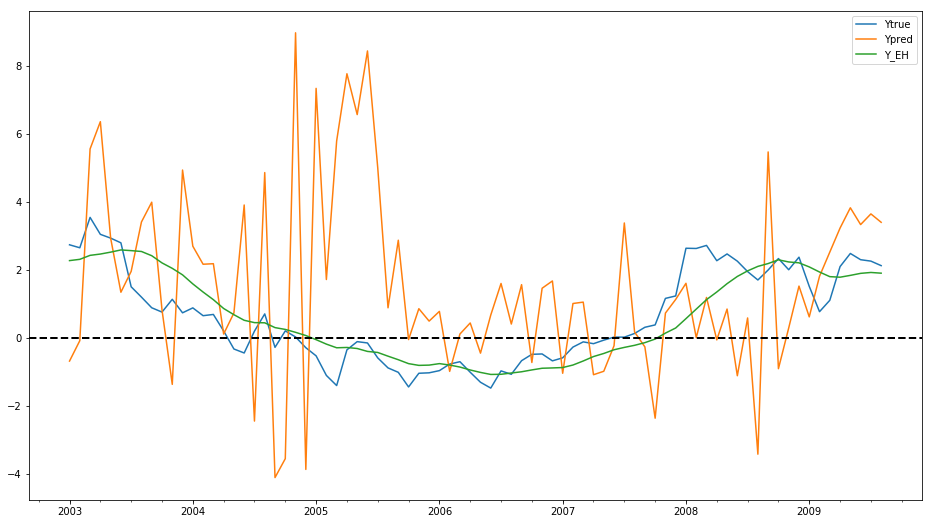

In [84]:
fig = plt.figure(figsize = (16,9))
ax = plt.gca()
res[['Ytrue', 'Ypred', 'Y_EH']].plot(ax=ax)
ax.axhline(0, linestyle='--', color='black', lw=2)
plt.legend()
plt.show()

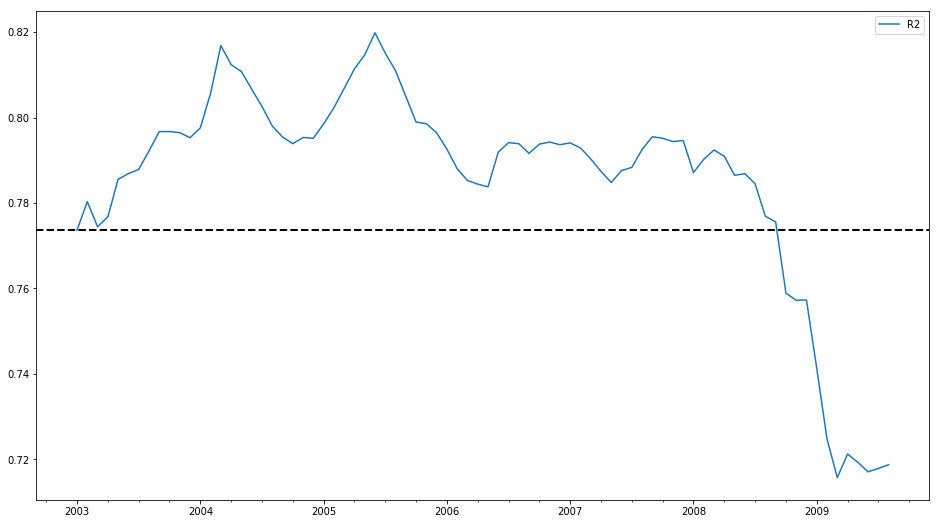

In [85]:
fig = plt.figure(figsize = (16,9))
ax = plt.gca()
res[['R2']].plot(ax=ax)
ax.axhline(res['R2'].iloc[0], linestyle='--', color='black', lw=2)
plt.legend()
plt.show()

In [86]:
res.to_csv("res_outsample_of_" + Yname + ".csv")

# Year 3

In [87]:
Yname = "yr3"

## In sample

In [88]:
Factor = pd.concat([dfFactor, pcaFactor], axis=1)
Factor_normal, _ = minmaxscaler_for_train(Factor)

Y = LogExcessReturn[Yname].loc[begin_date: mid_date]
Y = Y.shift(-1).dropna()

In [89]:
Y.index

DatetimeIndex(['1980-01-31', '1980-02-29', '1980-03-31', '1980-04-30',
               '1980-05-31', '1980-06-30', '1980-07-31', '1980-08-31',
               '1980-09-30', '1980-10-31',
               ...
               '2002-02-28', '2002-03-31', '2002-04-30', '2002-05-31',
               '2002-06-30', '2002-07-31', '2002-08-31', '2002-09-30',
               '2002-10-31', '2002-11-30'],
              dtype='datetime64[ns]', name='Date', length=275, freq=None)

In [90]:
GOODname = [
        'CLI', 
        'MktRF','HML', 'RF', 
        'BWSENTcoth', 'BWSENT', 
        'BV',
        'CP', 
        'tech_class4', 'tech_class5', 'tech_class6',
        'labor_market', 'housing', 'consumption', 'price','stock', 
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[GOODname].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr3   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     39.93
Date:                Sat, 08 Dec 2018   Prob (F-statistic):           7.66e-64
Time:                        11:31:20   Log-Likelihood:                -596.64
No. Observations:                 275   AIC:                             1229.
Df Residuals:                     257   BIC:                             1294.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CLI             -6.7840      1.688     -4.019      0.000     -10.108      -3.460
MktRF           12.5104      2.021      6.189      0.000       8.530      16.491
HML              4.7862      1.155      4.142      0.000       2.511       7.062
RF             -10.0901      1.396     -7.227      0.000     -12.840      -7.341
BWSENTcoth     -16.3459      2.913     -5.612      0.000     -22.081     -10.610
BWSENT          11.7420      2.600      4.516      0.000       6.622      16.862
BV              -2.7348      1.043     -2.622      0.009      -4.789      -0.681
CP               2.6064      1.609      1.620      0.106      -0.561       5.774
tech_class4      2.3321      3.959      0.589      0.556      -5.464      10.128
tech_class5    -32.5069      5.775     -5.629      0.000     -43.879     -21.134
tech_class6     17.3224      8.798      1.969      0.050      -0.003      34.648
labor_market    -1.5213      1.074     -1.416      0.158      -3.637       0.595
housing         -7.0720      1.654     -4.275      0.000     -10.330      -3.814
consumption     -2.9763      1.231     -2.417      0.016      -5.401      -0.551
price           10.7909      1.051     10.271      0.000       8.722      12.860
stock            0.6721      1.847      0.364      0.716      -2.965       4.310
PYD             -6.1427      2.074     -2.962      0.003     -10.226      -2.059
Industries      12.1280      2.996      4.048      0.000       6.229      18.027
==============================================================================
Omnibus:                        4.181   Durbin-Watson:                   0.825
Prob(Omnibus):                  0.124   Jarque-Bera (JB):                4.760
Skew:                           0.124   Prob(JB):                       0.0925
Kurtosis:                       3.595   Cond. No.                         131.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Out sample

In [91]:
Y = LogExcessReturn[Yname]

res = pd.DataFrame(columns = ['Ytrue', 'Ypred', 'R2', 'AdjR2', 'Y_EH', 'R2OS', 
                              'InsampleBegin', 'InsampleEnd', 'OutsampleAt'])
resModel = {}

indextime = list(Factor.index)
insample = 276

for i in range(insample, len(indextime)-3):
    begin_date_train = indextime[i - insample]
    end_date_train = indextime[i-1]
    begin_date_test = indextime[i]  
    end_date_test = indextime[i+1] + pd.Timedelta(days = 10)
    
    Factor_train, Factor_test = get_Factor(begin_date_train, end_date_train, 
                                           begin_date_test, end_date_test)
    
    Y_train = Y.loc[begin_date_train + pd.Timedelta(days = 10): end_date_train + pd.Timedelta(days = 40)]
    Y_test = Y.loc[begin_date_test: end_date_test + pd.Timedelta(days = 10)]
    
    Y_pred, model = prediction(Factor_train, Y_train, Factor_test)
    
    
    now = Y_test.index[0]
    Ytrue = Y_test.loc[now]
    Ypred = Y_pred.loc[now]
    R2 = model.rsquared
    AdjR2 = model.rsquared_adj
    Y_BH = np.mean(Y_train.iloc[-10:])
    R2OS = get_R2OS(Ytrue, Ypred, Y_BH)
    
    res.loc[now] = [
        Ytrue, Ypred, R2, AdjR2, Y_BH, R2OS,
        begin_date_train, end_date_train, begin_date_test
    ]
    resModel[now] = resModel
    
    print(now)

2003-01-31 00:00:00
2003-02-28 00:00:00
2003-03-31 00:00:00
2003-04-30 00:00:00
2003-05-31 00:00:00
2003-06-30 00:00:00
2003-07-31 00:00:00
2003-08-31 00:00:00
2003-09-30 00:00:00
2003-10-31 00:00:00
2003-11-30 00:00:00
2003-12-31 00:00:00
2004-01-31 00:00:00
2004-02-29 00:00:00
2004-03-31 00:00:00
2004-04-30 00:00:00
2004-05-31 00:00:00
2004-06-30 00:00:00
2004-07-31 00:00:00
2004-08-31 00:00:00
2004-09-30 00:00:00
2004-10-31 00:00:00
2004-11-30 00:00:00
2004-12-31 00:00:00
2005-01-31 00:00:00
2005-02-28 00:00:00
2005-03-31 00:00:00
2005-04-30 00:00:00
2005-05-31 00:00:00
2005-06-30 00:00:00
2005-07-31 00:00:00
2005-08-31 00:00:00
2005-09-30 00:00:00
2005-10-31 00:00:00
2005-11-30 00:00:00
2005-12-31 00:00:00
2006-01-31 00:00:00
2006-02-28 00:00:00
2006-03-31 00:00:00
2006-04-30 00:00:00
2006-05-31 00:00:00
2006-06-30 00:00:00
2006-07-31 00:00:00
2006-08-31 00:00:00
2006-09-30 00:00:00
2006-10-31 00:00:00
2006-11-30 00:00:00
2006-12-31 00:00:00
2007-01-31 00:00:00
2007-02-28 00:00:00


In [92]:
RMSE = get_RMSE(res['Ytrue'], res['Ypred'])
RMSE

9.14918457517994

In [93]:
R2OS = get_R2OS(res['Ytrue'], res['Ypred'], res['Y_EH'])
R2OS

-42.25598911727321

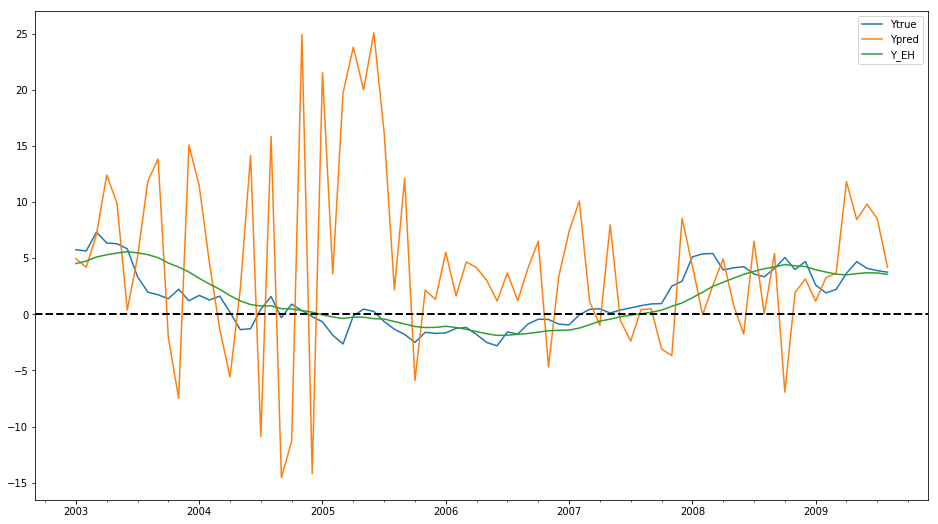

In [96]:
fig = plt.figure(figsize = (16,9))
ax = plt.gca()
res[['Ytrue', 'Ypred', 'Y_EH']].plot(ax=ax)
ax.axhline(0, linestyle='--', color='black', lw=2)
plt.legend()
plt.show()

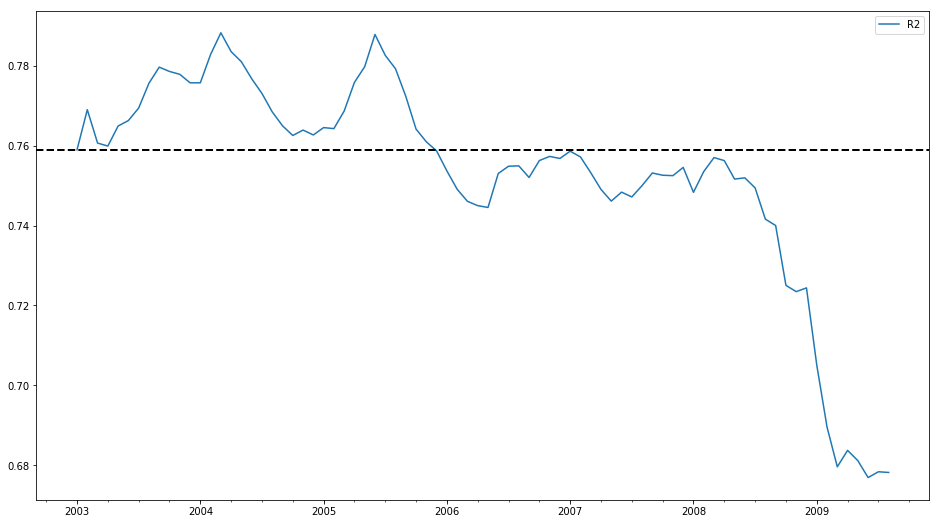

In [95]:
fig = plt.figure(figsize = (16,9))
ax = plt.gca()
res[['R2']].plot(ax=ax)
ax.axhline(res['R2'].iloc[0], linestyle='--', color='black', lw=2)
plt.legend()
plt.show()

In [97]:
res.to_csv("res_outsample_of_" + Yname + ".csv")

# Year 4

In [98]:
Yname = "yr4"

## In sample

In [99]:
Factor = pd.concat([dfFactor, pcaFactor], axis=1)
Factor_normal, _ = minmaxscaler_for_train(Factor)

Y = LogExcessReturn[Yname].loc[begin_date: mid_date]
Y = Y.shift(-1).dropna()

In [100]:
Y.index

DatetimeIndex(['1980-01-31', '1980-02-29', '1980-03-31', '1980-04-30',
               '1980-05-31', '1980-06-30', '1980-07-31', '1980-08-31',
               '1980-09-30', '1980-10-31',
               ...
               '2002-02-28', '2002-03-31', '2002-04-30', '2002-05-31',
               '2002-06-30', '2002-07-31', '2002-08-31', '2002-09-30',
               '2002-10-31', '2002-11-30'],
              dtype='datetime64[ns]', name='Date', length=275, freq=None)

In [101]:
GOODname = [
        'CLI', 
        'MktRF','HML', 'RF', 
        'BWSENTcoth', 'BWSENT', 
        'BV',
        'CP', 
        'tech_class4', 'tech_class5', 'tech_class6',
        'labor_market', 'housing', 'consumption', 'price','stock', 
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[GOODname].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr4   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     38.41
Date:                Sat, 08 Dec 2018   Prob (F-statistic):           2.71e-62
Time:                        11:32:27   Log-Likelihood:                -691.37
No. Observations:                 275   AIC:                             1419.
Df Residuals:                     257   BIC:                             1484.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CLI            -10.4598      2.382     -4.391      0.000     -15.150      -5.769
MktRF           19.5893      2.853      6.867      0.000      13.972      25.207
HML              7.6820      1.631      4.711      0.000       4.471      10.893
RF             -14.5959      1.970     -7.408      0.000     -18.476     -10.716
BWSENTcoth     -21.4344      4.110     -5.215      0.000     -29.528     -13.341
BWSENT          14.6518      3.669      3.993      0.000       7.426      21.877
BV              -3.8228      1.472     -2.597      0.010      -6.721      -0.924
CP               2.5900      2.270      1.141      0.255      -1.880       7.060
tech_class4      4.3512      5.587      0.779      0.437      -6.651      15.353
tech_class5    -47.9334      8.150     -5.882      0.000     -63.982     -31.884
tech_class6     16.7567     12.416      1.350      0.178      -7.693      41.206
labor_market    -1.9873      1.516     -1.311      0.191      -4.973       0.999
housing        -11.3893      2.334     -4.879      0.000     -15.986      -6.792
consumption     -4.3339      1.738     -2.494      0.013      -7.756      -0.912
price           15.0526      1.483     10.153      0.000      12.133      17.972
stock            1.3679      2.607      0.525      0.600      -3.765       6.501
PYD             -9.6129      2.926     -3.285      0.001     -15.376      -3.850
Industries      19.1873      4.228      4.539      0.000      10.862      27.513
==============================================================================
Omnibus:                        1.610   Durbin-Watson:                   0.814
Prob(Omnibus):                  0.447   Jarque-Bera (JB):                1.357
Skew:                           0.070   Prob(JB):                        0.507
Kurtosis:                       3.314   Cond. No.                         131.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Out sample

In [102]:
Y = LogExcessReturn[Yname]

res = pd.DataFrame(columns = ['Ytrue', 'Ypred', 'R2', 'AdjR2', 'Y_EH', 'R2OS', 
                              'InsampleBegin', 'InsampleEnd', 'OutsampleAt'])
resModel = {}

indextime = list(Factor.index)
insample = 276

for i in range(insample, len(indextime)-3):
    begin_date_train = indextime[i - insample]
    end_date_train = indextime[i-1]
    begin_date_test = indextime[i]  
    end_date_test = indextime[i+1] + pd.Timedelta(days = 10)
    
    Factor_train, Factor_test = get_Factor(begin_date_train, end_date_train, 
                                           begin_date_test, end_date_test)
    
    Y_train = Y.loc[begin_date_train + pd.Timedelta(days = 10): end_date_train + pd.Timedelta(days = 40)]
    Y_test = Y.loc[begin_date_test: end_date_test + pd.Timedelta(days = 10)]
    
    Y_pred, model = prediction(Factor_train, Y_train, Factor_test)
    
    
    now = Y_test.index[0]
    Ytrue = Y_test.loc[now]
    Ypred = Y_pred.loc[now]
    R2 = model.rsquared
    AdjR2 = model.rsquared_adj
    Y_BH = np.mean(Y_train.iloc[-10:])
    R2OS = get_R2OS(Ytrue, Ypred, Y_BH)
    
    res.loc[now] = [
        Ytrue, Ypred, R2, AdjR2, Y_BH, R2OS,
        begin_date_train, end_date_train, begin_date_test
    ]
    resModel[now] = resModel
    
    print(now)

2003-01-31 00:00:00
2003-02-28 00:00:00
2003-03-31 00:00:00
2003-04-30 00:00:00
2003-05-31 00:00:00
2003-06-30 00:00:00
2003-07-31 00:00:00
2003-08-31 00:00:00
2003-09-30 00:00:00
2003-10-31 00:00:00
2003-11-30 00:00:00
2003-12-31 00:00:00
2004-01-31 00:00:00
2004-02-29 00:00:00
2004-03-31 00:00:00
2004-04-30 00:00:00
2004-05-31 00:00:00
2004-06-30 00:00:00
2004-07-31 00:00:00
2004-08-31 00:00:00
2004-09-30 00:00:00
2004-10-31 00:00:00
2004-11-30 00:00:00
2004-12-31 00:00:00
2005-01-31 00:00:00
2005-02-28 00:00:00
2005-03-31 00:00:00
2005-04-30 00:00:00
2005-05-31 00:00:00
2005-06-30 00:00:00
2005-07-31 00:00:00
2005-08-31 00:00:00
2005-09-30 00:00:00
2005-10-31 00:00:00
2005-11-30 00:00:00
2005-12-31 00:00:00
2006-01-31 00:00:00
2006-02-28 00:00:00
2006-03-31 00:00:00
2006-04-30 00:00:00
2006-05-31 00:00:00
2006-06-30 00:00:00
2006-07-31 00:00:00
2006-08-31 00:00:00
2006-09-30 00:00:00
2006-10-31 00:00:00
2006-11-30 00:00:00
2006-12-31 00:00:00
2007-01-31 00:00:00
2007-02-28 00:00:00


In [103]:
RMSE = get_RMSE(res['Ytrue'], res['Ypred'])
RMSE

13.863697155345529

In [104]:
R2OS = get_R2OS(res['Ytrue'], res['Ypred'], res['Y_EH'])
R2OS

-46.08499764247577

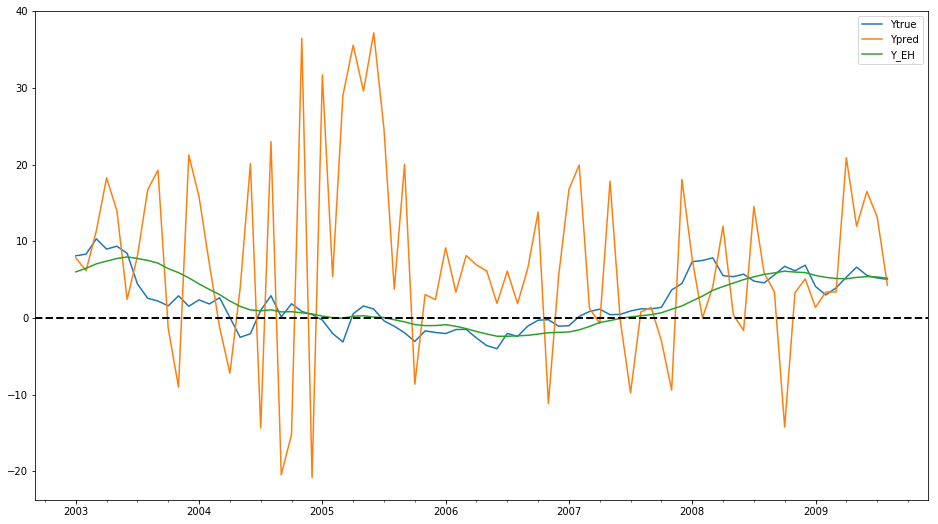

In [105]:
fig = plt.figure(figsize = (16,9))
ax = plt.gca()
res[['Ytrue', 'Ypred', 'Y_EH']].plot(ax=ax)
ax.axhline(0, linestyle='--', color='black', lw=2)
plt.legend()
plt.show()

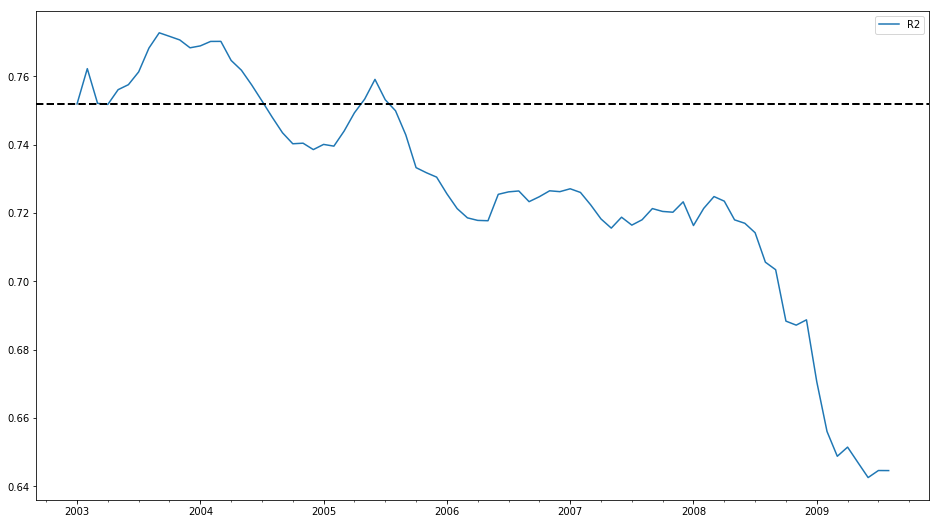

In [106]:
fig = plt.figure(figsize = (16,9))
ax = plt.gca()
res[['R2']].plot(ax=ax)
ax.axhline(res['R2'].iloc[0], linestyle='--', color='black', lw=2)
plt.legend()
plt.show()

In [107]:
res.to_csv("res_outsample_of_" + Yname + ".csv")

# Year 5

In [108]:
Yname = "yr5"

## In sample

In [109]:
Factor = pd.concat([dfFactor, pcaFactor], axis=1)
Factor_normal, _ = minmaxscaler_for_train(Factor)

Y = LogExcessReturn[Yname].loc[begin_date: mid_date]
Y = Y.shift(-1).dropna()

In [110]:
Y.index

DatetimeIndex(['1980-01-31', '1980-02-29', '1980-03-31', '1980-04-30',
               '1980-05-31', '1980-06-30', '1980-07-31', '1980-08-31',
               '1980-09-30', '1980-10-31',
               ...
               '2002-02-28', '2002-03-31', '2002-04-30', '2002-05-31',
               '2002-06-30', '2002-07-31', '2002-08-31', '2002-09-30',
               '2002-10-31', '2002-11-30'],
              dtype='datetime64[ns]', name='Date', length=275, freq=None)

In [111]:
GOODname = [
        'CLI', 
        'MktRF','HML', 'RF', 
        'BWSENTcoth', 'BWSENT', 
        'BV',
        'CP', 
        'tech_class4', 'tech_class5', 'tech_class6',
        'labor_market', 'housing', 'consumption', 'price','stock', 
        'PYD','Industries'
       ]
model = sm.OLS(Y, Factor_normal[GOODname].loc[Y.index])
result = model.fit().summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    yr5   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     33.54
Date:                Sat, 08 Dec 2018   Prob (F-statistic):           5.18e-57
Time:                        11:33:20   Log-Likelihood:                -758.38
No. Observations:                 275   AIC:                             1553.
Df Residuals:                     257   BIC:                             1618.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CLI            -13.4549      3.039     -4.427      0.000     -19.440      -7.470
MktRF           26.1995      3.640      7.198      0.000      19.032      33.367
HML             10.1276      2.081      4.868      0.000       6.030      14.225
RF             -17.9552      2.514     -7.142      0.000     -22.906     -13.004
BWSENTcoth     -25.6997      5.244     -4.901      0.000     -36.027     -15.372
BWSENT          17.7080      4.682      3.782      0.000       8.489      26.927
BV              -5.2391      1.878     -2.790      0.006      -8.937      -1.541
CP               0.8576      2.896      0.296      0.767      -4.846       6.561
tech_class4      5.8143      7.128      0.816      0.415      -8.223      19.852
tech_class5    -60.1157     10.399     -5.781      0.000     -80.593     -39.638
tech_class6     17.6712     15.842      1.115      0.266     -13.525      48.867
labor_market    -2.3478      1.935     -1.214      0.226      -6.158       1.462
housing        -14.9812      2.979     -5.030      0.000     -20.847      -9.116
consumption     -6.0599      2.217     -2.733      0.007     -10.426      -1.694
price           18.3555      1.892      9.703      0.000      14.630      22.081
stock            1.1236      3.326      0.338      0.736      -5.426       7.673
PYD            -11.9692      3.734     -3.206      0.002     -19.322      -4.616
Industries      26.1787      5.394      4.853      0.000      15.556      36.801
==============================================================================
Omnibus:                        1.387   Durbin-Watson:                   0.849
Prob(Omnibus):                  0.500   Jarque-Bera (JB):                1.094
Skew:                           0.119   Prob(JB):                        0.579
Kurtosis:                       3.196   Cond. No.                         131.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Out sample

In [112]:
Y = LogExcessReturn[Yname]

res = pd.DataFrame(columns = ['Ytrue', 'Ypred', 'R2', 'AdjR2', 'Y_EH', 'R2OS', 
                              'InsampleBegin', 'InsampleEnd', 'OutsampleAt'])
resModel = {}

indextime = list(Factor.index)
insample = 276

for i in range(insample, len(indextime)-3):
    begin_date_train = indextime[i - insample]
    end_date_train = indextime[i-1]
    begin_date_test = indextime[i]  
    end_date_test = indextime[i+1] + pd.Timedelta(days = 10)
    
    Factor_train, Factor_test = get_Factor(begin_date_train, end_date_train, 
                                           begin_date_test, end_date_test)
    
    Y_train = Y.loc[begin_date_train + pd.Timedelta(days = 10): end_date_train + pd.Timedelta(days = 40)]
    Y_test = Y.loc[begin_date_test: end_date_test + pd.Timedelta(days = 10)]
    
    Y_pred, model = prediction(Factor_train, Y_train, Factor_test)
    
    
    now = Y_test.index[0]
    Ytrue = Y_test.loc[now]
    Ypred = Y_pred.loc[now]
    R2 = model.rsquared
    AdjR2 = model.rsquared_adj
    Y_BH = np.mean(Y_train.iloc[-10:])
    R2OS = get_R2OS(Ytrue, Ypred, Y_BH)
    
    res.loc[now] = [
        Ytrue, Ypred, R2, AdjR2, Y_BH, R2OS,
        begin_date_train, end_date_train, begin_date_test
    ]
    resModel[now] = resModel
    
    print(now)

2003-01-31 00:00:00
2003-02-28 00:00:00
2003-03-31 00:00:00
2003-04-30 00:00:00
2003-05-31 00:00:00
2003-06-30 00:00:00
2003-07-31 00:00:00
2003-08-31 00:00:00
2003-09-30 00:00:00
2003-10-31 00:00:00
2003-11-30 00:00:00
2003-12-31 00:00:00
2004-01-31 00:00:00
2004-02-29 00:00:00
2004-03-31 00:00:00
2004-04-30 00:00:00
2004-05-31 00:00:00
2004-06-30 00:00:00
2004-07-31 00:00:00
2004-08-31 00:00:00
2004-09-30 00:00:00
2004-10-31 00:00:00
2004-11-30 00:00:00
2004-12-31 00:00:00
2005-01-31 00:00:00
2005-02-28 00:00:00
2005-03-31 00:00:00
2005-04-30 00:00:00
2005-05-31 00:00:00
2005-06-30 00:00:00
2005-07-31 00:00:00
2005-08-31 00:00:00
2005-09-30 00:00:00
2005-10-31 00:00:00
2005-11-30 00:00:00
2005-12-31 00:00:00
2006-01-31 00:00:00
2006-02-28 00:00:00
2006-03-31 00:00:00
2006-04-30 00:00:00
2006-05-31 00:00:00
2006-06-30 00:00:00
2006-07-31 00:00:00
2006-08-31 00:00:00
2006-09-30 00:00:00
2006-10-31 00:00:00
2006-11-30 00:00:00
2006-12-31 00:00:00
2007-01-31 00:00:00
2007-02-28 00:00:00


In [113]:
RMSE = get_RMSE(res['Ytrue'], res['Ypred'])
RMSE

19.233152934923247

In [114]:
R2OS = get_R2OS(res['Ytrue'], res['Ypred'], res['Y_EH'])
R2OS

-56.436222809989665

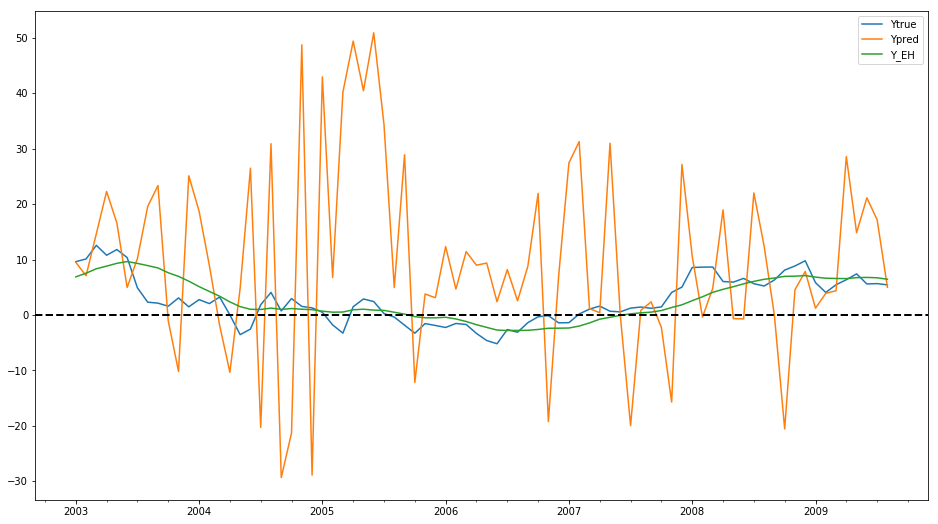

In [115]:
fig = plt.figure(figsize = (16,9))
ax = plt.gca()
res[['Ytrue', 'Ypred', 'Y_EH']].plot(ax=ax)
ax.axhline(0, linestyle='--', color='black', lw=2)
plt.legend()
plt.show()

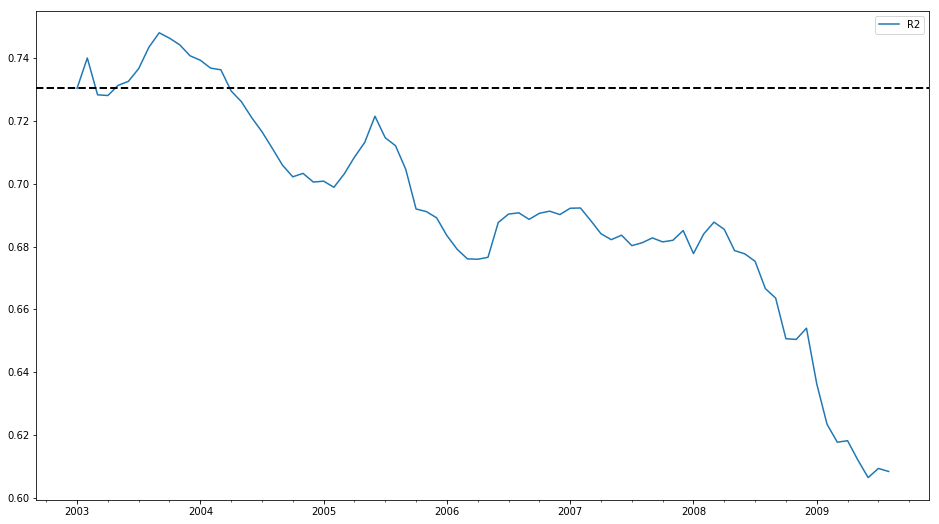

In [116]:
fig = plt.figure(figsize = (16,9))
ax = plt.gca()
res[['R2']].plot(ax=ax)
ax.axhline(res['R2'].iloc[0], linestyle='--', color='black', lw=2)
plt.legend()
plt.show()

In [117]:
res.to_csv("res_outsample_of_" + Yname + ".csv")

## plot

In [129]:
final = pd.DataFrame(index = res.index)

for i in range(2, 6):
    Yname = "yr" + str(i)
    resy = pd.read_csv("res_outsample_of_" + Yname + ".csv")
    resy = resy.set_index("Unnamed: 0")
    resy.index = pd.to_datetime(resy.index)
    
    final['Ytrue_' + Yname] = resy['Ytrue']
    final['Ypred_' + Yname] = resy['Ypred']
    final['Y_EH_' + Yname] = resy['Y_EH']
    final['R2_' + Yname] = resy['R2']

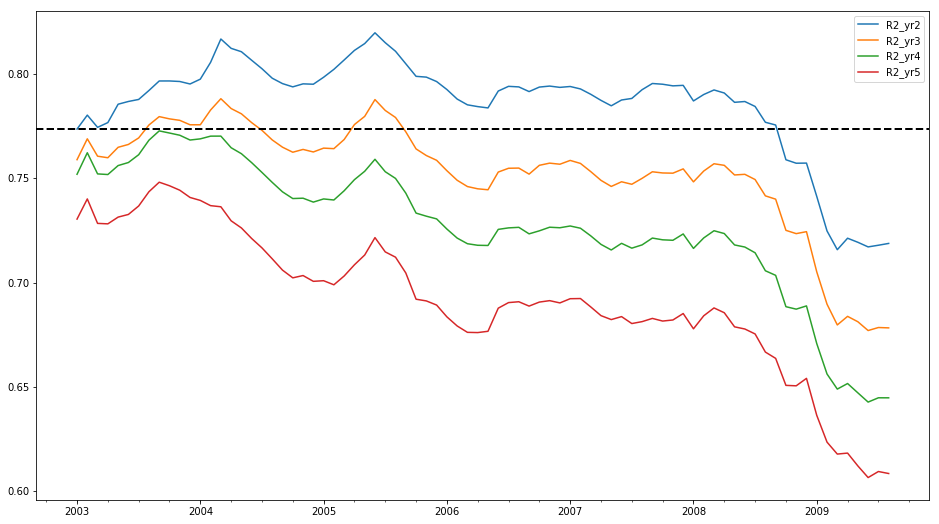

In [130]:
fig = plt.figure(figsize = (16,9))
ax = plt.gca()
final[['R2_yr2', 'R2_yr3', 'R2_yr4', 'R2_yr5']].plot(ax=ax)
ax.axhline(final['R2_yr2'].iloc[0], linestyle='--', color='black', lw=2)
plt.legend()
plt.show()

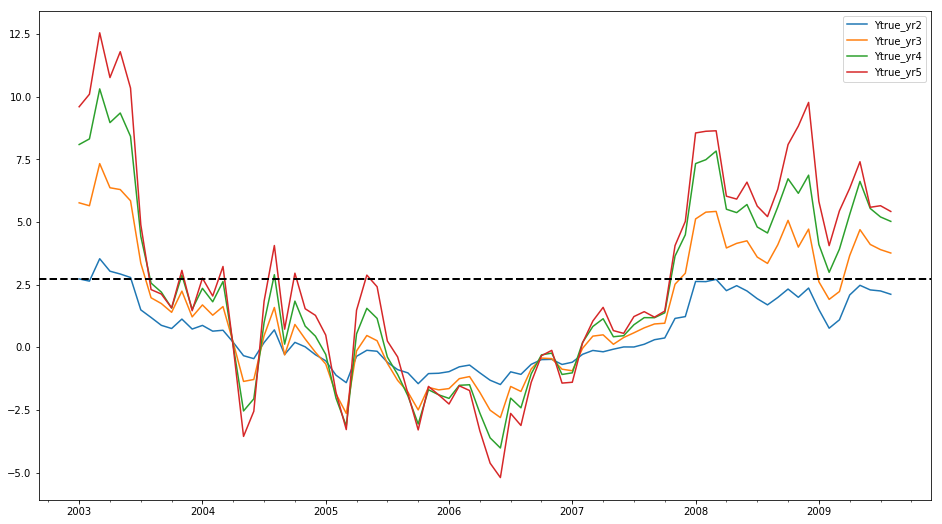

In [131]:
fig = plt.figure(figsize = (16,9))
ax = plt.gca()
final[['Ytrue_yr2', 'Ytrue_yr3', 'Ytrue_yr4', 'Ytrue_yr5']].plot(ax=ax)
ax.axhline(final['Ytrue_yr2'].iloc[0], linestyle='--', color='black', lw=2)
plt.legend()
plt.show()

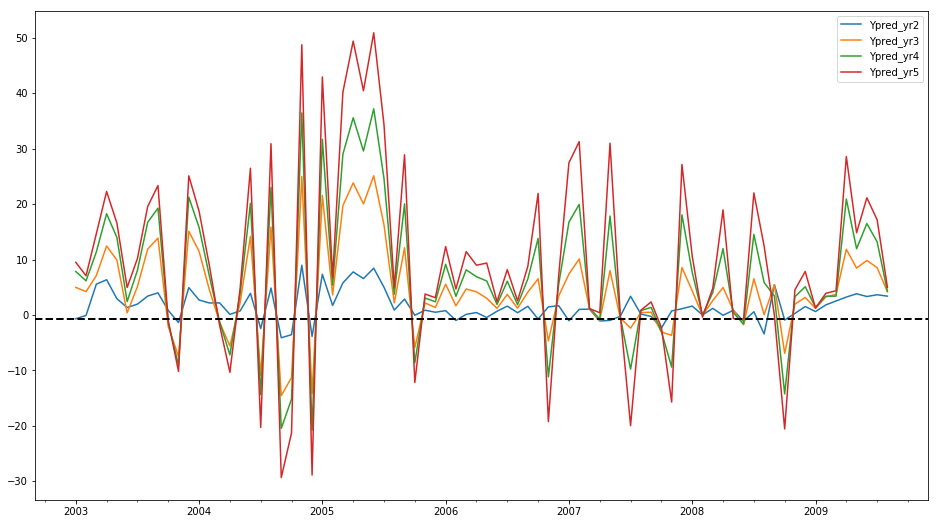

In [132]:
fig = plt.figure(figsize = (16,9))
ax = plt.gca()
final[['Ypred_yr2', 'Ypred_yr3', 'Ypred_yr4', 'Ypred_yr5']].plot(ax=ax)
ax.axhline(final['Ypred_yr2'].iloc[0], linestyle='--', color='black', lw=2)
plt.legend()
plt.show()

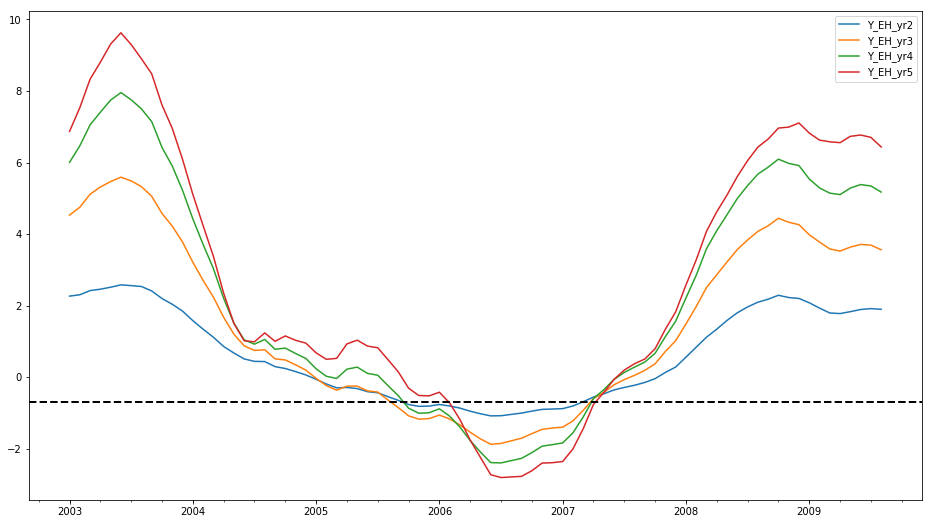

In [133]:
fig = plt.figure(figsize = (16,9))
ax = plt.gca()
final[['Y_EH_yr2', 'Y_EH_yr3', 'Y_EH_yr4', 'Y_EH_yr5']].plot(ax=ax)
ax.axhline(final['Ypred_yr2'].iloc[0], linestyle='--', color='black', lw=2)
plt.legend()
plt.show()

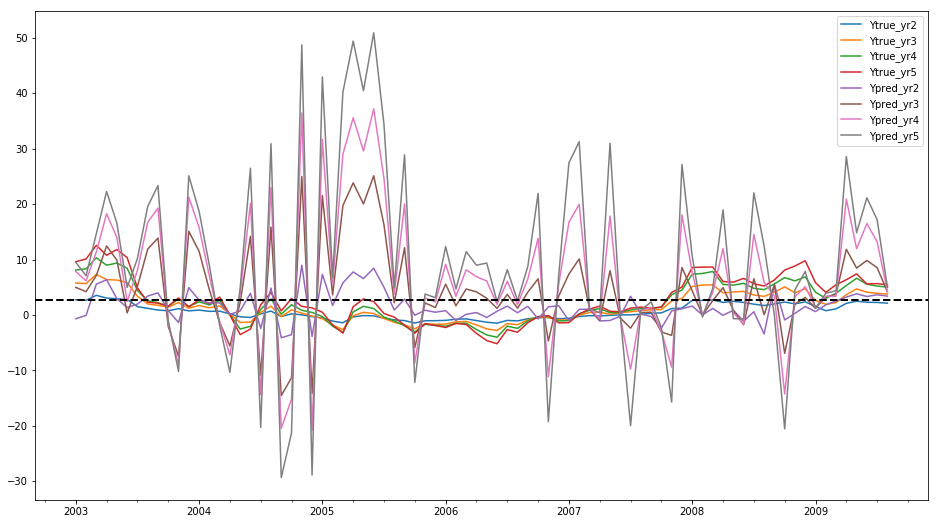

In [65]:
fig = plt.figure(figsize = (16,9))
ax = plt.gca()
final[['Ytrue_yr2', 'Ytrue_yr3', 'Ytrue_yr4', 'Ytrue_yr5',
      'Ypred_yr2', 'Ypred_yr3', 'Ypred_yr4', 'Ypred_yr5']].plot(ax=ax)
ax.axhline(final['Ytrue_yr2'].iloc[0], linestyle='--', color='black', lw=2)
plt.legend()
plt.show()

In [68]:
def get_CP(begin_date, end_date):
    bondprice = pd.read_csv(os.path.join(datapath, "bondprice.csv"))
    bondprice = bondprice.set_index("Date")
    bondprice.index = pd.to_datetime(bondprice.index)
    bondprice = bondprice.loc[begin_date: end_date]
    
    import statsmodels.api as sm
    def cp_regress(bondprice):
        T = len(bondprice)
        yields = -np.log(bondprice.values/100) * np.ones((T, 1))*np.asarray([[1/1,1/2,1/3,1/4,1/5]])
        mats = np.asarray([1,2,3,4,5])
        prices = -(np.ones((T,1)) * mats) * yields
        forwards = prices[:,0:4] - prices[:,1:5]
        fs = forwards - yields[:,0][np.newaxis].T * np.ones((1,4))

        hpr = prices[12:,0:4] - prices[:T-12,1:5]
        hprx = hpr - yields[:T-12,0][np.newaxis].T * np.ones((1,4))
        hpr = np.vstack([np.zeros((12,4)), hpr])
        hprx = np.vstack([np.zeros((12,4)), hprx])
        beg = 140

        HPRX = 100 * hprx[beg+12-1:T,:]
        AHPRX = np.mean(HPRX.T, axis=0)[np.newaxis].T
        Ts = T-beg-12+1;
        FT = np.hstack([np.ones((Ts,1)), 100 * yields[beg-1:T-12,0][np.newaxis].T, 100 * forwards[beg-1:T-12,:]])
        ALL = np.hstack([np.ones((T,1)), 100 * yields[:,0][np.newaxis].T, 100 * forwards[:,:]])
        gamma = sm.OLS(AHPRX, FT).fit().params
        CP = np.dot(ALL, gamma[np.newaxis].T)
        return gamma, CP, hprx
    _, CP, _= cp_regress(bondprice)
    CP = pd.DataFrame(CP, bondprice.index, columns=["CP"])
    return CP

def get_techFactor_train(begin_date, end_date):
    techFactor = pd.read_csv(os.path.join(datapath, "technicalDJIA.csv"))
    techFactor = techFactor.set_index("Date")
    techFactor.index = pd.to_datetime(techFactor.index)
    techFactor = techFactor.loc[begin_date: end_date]
    with open(os.path.join(datapath, "class_for_tech.json"), "r") as file:
        techclass = json.load(file)

    columns = ["tech_" + value for value in techclass.keys()]
    techFactorPca = pd.DataFrame(columns=columns, index = techFactor.index)
    techPcaClass = {column: None for column in columns}
    
    for i in range(len(techclass.keys())):
        name = "tech_class" +  str(i)
        column = techclass["class" +  str(i)]
        pca = PCA(n_components=1)
        techFactorPca[name] = pca.fit_transform(techFactor[column])
        techPcaClass[name] = pca
    return techFactorPca, techPcaClass

def get_techFactor_test(begin_date, end_date, techPcaClass):
    techFactor = pd.read_csv(os.path.join(datapath, "technicalDJIA.csv"))
    techFactor = techFactor.set_index("Date")
    techFactor.index = pd.to_datetime(techFactor.index)
    techFactor = techFactor.loc[begin_date: end_date]
    with open(os.path.join(datapath, "class_for_tech.json"), "r") as file:
        techclass = json.load(file)
    
    columns = ["tech_" + value for value in techclass.keys()]
    techFactorPca = pd.DataFrame(columns=columns, index = techFactor.index)
    
    for i in range(len(techclass.keys())):
        name = "tech_class" +  str(i)
        column = techclass["class" +  str(i)]
        pca = techPcaClass[name]
        techFactorPca[name] = pca.fit_transform(techFactor[column])
    
    return techFactorPca
    

def get_macroFactor_train(begin_date, end_date):
    macroFactor = pd.read_csv(os.path.join(datapath, "macro_data.csv"))
    macroFactor = macroFactor.set_index("Date")
    macroFactor.index = pd.to_datetime(macroFactor.index)
    macroFactor = macroFactor.loc[begin_date: end_date]
    with open(os.path.join(datapath, "method_for_macro_raw_data.json"), "r") as file:
        method_for_macro = json.load(file)

    macroFactorPca = pd.DataFrame(columns=method_for_macro.keys(), index=macroFactor.index)
    macroPcaClass = {name: None for name in method_for_macro.keys() }
    
    for name in method_for_macro.keys():
        column = list(method_for_macro[name].keys())
        pca = PCA(n_components=1)
        macroFactorPca[name] = pca.fit_transform(macroFactor[column])
        macroPcaClass[name] = pca
    return macroFactorPca, macroPcaClass

def get_macroFactor_test(begin_date, end_date, macroPcaClass):
    macroFactor = pd.read_csv(os.path.join(datapath, "macro_data.csv"))
    macroFactor = macroFactor.set_index("Date")
    macroFactor.index = pd.to_datetime(macroFactor.index)
    macroFactor = macroFactor.loc[begin_date: end_date]
    with open(os.path.join(datapath, "method_for_macro_raw_data.json"), "r") as file:
        method_for_macro = json.load(file)

    macroFactorPca = pd.DataFrame(columns=method_for_macro.keys(), index=macroFactor.index)
    
    for name in method_for_macro.keys():
        column = list(method_for_macro[name].keys())
        pca = macroPcaClass[name]
        macroFactorPca[name] = pca.fit_transform(macroFactor[column])
    return macroFactorPca
    

def get_financialFactor_train(begin_date, end_date):
    financialFactor = pd.read_csv(os.path.join(datapath, "financial_data.csv"))
    financialFactor = financialFactor.set_index("Date")
    financialFactor.index = pd.to_datetime(financialFactor.index)
    financialFactor = financialFactor.loc[begin_date: end_date]
    with open(os.path.join(datapath, "class_of_financial.json"), "r") as file:
        class_of_financial = json.load(file)

    financialFactorPca = pd.DataFrame(columns=class_of_financial.keys(), index=financialFactor.index)
    financialPcaClass = {name: None for name in class_of_financial.keys()}
    
    for name in class_of_financial.keys():
        column = list(class_of_financial[name])
        pca = PCA(n_components=1)
        financialFactorPca[name] = pca.fit_transform(financialFactor[column])
        financialPcaClass[name] = pca

    return financialFactorPca, financialPcaClass

def get_financialFactor_test(begin_date, end_date, financialPcaClass):
    financialFactor = pd.read_csv(os.path.join(datapath, "financial_data.csv"))
    financialFactor = financialFactor.set_index("Date")
    financialFactor.index = pd.to_datetime(financialFactor.index)
    financialFactor = financialFactor.loc[begin_date: end_date]
    with open(os.path.join(datapath, "class_of_financial.json"), "r") as file:
        class_of_financial = json.load(file)

    financialFactorPca = pd.DataFrame(columns=class_of_financial.keys(), index=financialFactor.index)
    
    for name in class_of_financial.keys():
        column = list(class_of_financial[name])
        pca = financialPcaClass[name]
        financialFactorPca[name] = pca.fit_transform(financialFactor[column])

    return financialFactorPca
    
    
def get_Factor(begin_date_train, end_date_train, 
               begin_date_test = None, end_date_test = None):
    dfFactor = pd.read_csv(os.path.join(datapath, "dfFactor.csv"))
    dfFactor = dfFactor.set_index("Date")
    dfFactor.index = pd.to_datetime(dfFactor.index)
    dfFactor = dfFactor.rename({"Amihud liquidity": "AmihudLiq",
                           "Mkt-RF": "MktRF",
                           "BWSENT^": "BWSENTcoth"}, axis = 1)
    dfFactor = dfFactor[['CLI', 'MktRF', 'HML', 'RF', 'BWSENTcoth', 'BWSENT', 'BV']]
    
    CP_train = get_CP(begin_date_train, end_date_train)
    
    techFactor_train, techPcaClass = get_techFactor_train(begin_date_train, end_date_train)
    macroFactor_train, macroPcaClass = get_macroFactor_train(begin_date_train, end_date_train)
    financialFactor_train, financialPcaClass = get_financialFactor_train(begin_date_train, end_date_train)
    
    pcaFactor_train = pd.concat([techFactor_train, macroFactor_train, financialFactor_train], axis=1)
    dfFactor_train = pd.concat([dfFactor.loc[begin_date_train: end_date_train], CP_train], axis=1)
    Factor_train = pd.concat([dfFactor_train, pcaFactor_train], axis=1)
    
    if begin_date_test is not None and end_date_test is not None:
        CP_test = get_CP(begin_date_train, end_date_test).loc[begin_date_test: end_date_test]

        techFactor_test = get_techFactor_test(begin_date_test, end_date_test, techPcaClass)
        macroFactor_test = get_macroFactor_test(begin_date_test, end_date_test, macroPcaClass)
        financialFactor_test = get_financialFactor_test(begin_date_test, end_date_test, financialPcaClass)

        pcaFactor_test = pd.concat([techFactor_test, macroFactor_test, financialFactor_test], axis=1)
        dfFactor_test = pd.concat([dfFactor.loc[begin_date_test: end_date_test], CP_test], axis=1)

        Factor_test = pd.concat([dfFactor_test, pcaFactor_test], axis=1)
    
    return Factor_train, Factor_test

In [69]:
def prediction(Factor_train, Y_train, Factor_test):
    Factor_normal_train, Factor_Infor = minmaxscaler_for_train(Factor_train)
    Factor_normal_test = minmaxscaler_for_test(Factor_test, Factor_Infor)
    Y_train.index = Factor_train.index
    
    model = sm.OLS(Y_train, Factor_normal_train).fit()
    result = model.summary()
    Ypred = model.predict(Factor_normal_test)
    
    return Ypred, model

def get_RMSE(Ytrue, Ypred):
    return np.sqrt(np.mean(np.square(Ytrue - Ypred)))

def get_R2OS(Ytrue, Ypred, Y_EH):
    return 1 - np.sum(np.square(Ytrue - Ypred)) / np.sum(np.square(Ytrue - Y_EH))